# OBJETIVOS



# Inicio

## Pacotes

In [122]:
import math
import pandas as pd
import numpy as np
import csv
import codecs
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
         r"\usepackage{url}",            # load additional packages
         r"\usepackage{unicode-math}",   # unicode math setup
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
})

import seaborn as sns
from scipy import stats
import random

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

with open('res_sub_tab.txt', 'w') as res_sub_tab:
    res_sub_tab.write('Tabelas Latex para os resultados dos métodos subjetivos')
    res_sub_tab.write('\n')
    res_sub_tab.close()

#Cores
ccmLBlue = (0.170/0.255,0.200/0.255,0.230/0.255)
ccmBlue = (0.020/0.255,0.080/0.255,0.200/0.255)
ccmDBlue = (0.025/0.255,0.050/0.255,0.120/0.255)
ccmRed = (0.190/0.255,0.0,0.0)
ccmOrange = (0.255/0.255,0.100/0.255,0.0)
ccmLGray = (0.210/0.255,0.210/0.255,0.210/0.255)
ccmDGray = (0.085/0.255,0.085/0.255,0.085/0.255)

cor1 = ccmRed
cor2 = ccmDBlue
cor3 = ccmLGray
cor4 = ccmOrange
cor5 = ccmLBlue
cor6 = ccmDGray
cor7 = ccmBlue

# Create an array with the colors you want to use
paletaCores = [cor1,cor2,cor3,cor4,cor5,cor6,cor7]
# Set your custom color palette
sns.set_palette(sns.color_palette(paletaCores))
plt.rcParams.update({'font.size': 22})


## Funções

### Tabela Latex

In [123]:
def tabela_latex(df,label,caption,teste,floatBarrier = False):
    tabela = pd.DataFrame.to_latex(df, label = label, caption = caption, position = '!htb', float_format="{:0.3f}".format)
    print(tabela)
    caminho = teste + '/Tabelas/' + label[4:] + '.tex'

    with open(caminho, 'w') as res_sub_tab:
        #res_sub_tab.write('\n' +'\n' + caption + '\n')
        res_sub_tab.write('\n' + tabela + '\n')
        if floatBarrier == True:
            res_sub_tab.write('\n \FloatBarrier \n')

def tabela_latex_sem_index(df,label,caption,teste,floatBarrier = False):
    tabela = pd.DataFrame.to_latex(df, label = label, caption = caption, position = '!htb', float_format="{:0.3f}".format, index = False)
    print(tabela)
    caminho = teste + '/Tabelas/' + label[4:] + '.tex'

    with open(caminho, 'w') as res_sub_tab:
        #res_sub_tab.write('\n' +'\n' + caption + '\n')
        res_sub_tab.write('\n' + tabela + '\n')
        if floatBarrier == True:
            res_sub_tab.write('\n \FloatBarrier \n')

### Anova

In [124]:
def AnovaTable(df):
    totalGeral = sum(sum(df.values))
    N = sum(df.count())
    replicas = df.count()[0]
    fatores = len(df.columns)
    mediaGeral = totalGeral/N

    # Somatória dos erros
    SS_t = 0
    SS_f = 0
    for a in df.columns:
        somaFator = 0
        SS_i = 0
        for n_ij in df[a]:
            SS_ij = (n_ij-mediaGeral)**2
            somaFator = somaFator + n_ij
            SS_t = SS_t + SS_ij
        SS_f = SS_f + (somaFator/len(df[a]) - mediaGeral)**2
    SS_f = SS_f*replicas
    SS_e = SS_t - SS_f

    SS_lista = [SS_f, SS_e, SS_t]

    # Graus de liberdade
    gL_1 = len(df.columns) - 1
    gL_2 = N - len(df.columns)
    gL = gL_1 + gL_2
    gL_lista = [gL_1, gL_2, gL]

    # Média dos erros
    MS_f = SS_f/gL_1
    MS_e = SS_e/gL_2
    MS_lista = [MS_f, MS_e, '']

    # Fator F
    F = MS_f/MS_e
    F_lista = [F,'' ,'' ]

    # p-Value
    p_value = stats.f.sf(F, gL_1, gL_2, loc=0, scale=1)
    P_value_list = [p_value, '', '']

    Fonte = ['Entre fatores', 'Dentro dos fatores', 'Total']

    df_summary = pd.DataFrame([], columns = ['Fonte', 'Soma dos quadrados', 'Graus de liberdade', 'Média quadrada', 'F', 'p-Value (F_0 > F)'])
    df_summary['Fonte'] = Fonte
    df_summary['Soma dos quadrados'] = SS_lista
    df_summary['Graus de liberdade'] = gL_lista
    df_summary['Média quadrada'] = MS_lista
    df_summary['F'] = F_lista
    df_summary['p-Value (F_0 > F)'] = P_value_list

    print(df_summary.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

    return df_summary

def LSDPostHocAnova(df):
    alpha = 0.05
    nomeFatores = df.columns
    
    totalGeral = sum(sum(df.values))
    N = sum(df.count())
    replicas = df.count()[0]
    mediaGeral = totalGeral/N

    # Graus de liberdade
    gL_2 = N - len(df.columns)

    # Somatória dos erros
    SS_t = 0
    SS_f = 0
    for a in df.columns:
        somaFator = 0
        SS_i = 0
        for n_ij in df[a]:
            SS_ij = (n_ij-mediaGeral)**2
            somaFator = somaFator + n_ij
            SS_t = SS_t + SS_ij
        SS_f = SS_f + (somaFator/len(df[a]) - mediaGeral)**2
    SS_f = SS_f*replicas
    SS_e = SS_t - SS_f

    # Média dos erros
    MS_e = SS_e/gL_2


    LSD = stats.t.isf(alpha,gL_2)/2 * np.sqrt(2*MS_e/len(df.iloc[:,1]))

    df_postHoc = pd.DataFrame([], columns = ['Comparação', 'Resultado'])
    comparaçãoLista = []
    resultadoLista = []

    mediaFator = []
    for a in df.columns:
        somaFator = 0
        for n_ij in df[a]:
            somaFator = somaFator + n_ij
        mediaFator.append(somaFator/len(df[a]))
    i = 0
    while i < len(mediaFator):
        j = 0
        while j < len(mediaFator):
            if (i<j and i!=j):
                comparaçãoLista.append(nomeFatores[i] + ' versus ' + nomeFatores[j])
                if (abs(mediaFator[i] - mediaFator[j])>=LSD):
                    resultadoLista.append('**H_1 : \mu_' + nomeFatores[i] + ' != \mu_' + nomeFatores[j] + '**')
                else:
                    resultadoLista.append('H_0 : \mu_' + nomeFatores[i] + ' == \mu_' + nomeFatores[j])
            j = j + 1
        i = i + 1
    df_postHoc['Comparação'] = comparaçãoLista
    df_postHoc['Resultado'] = resultadoLista
    print('Se a diferença entre alguma média for superior a {lsd:.2f} então a hipótese alternativa pode ser valida para essa determinada comparação'.format(lsd = LSD))
    print(df_postHoc.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

    return df_postHoc

def DunnettPostHocAnova(df,dun_0,controle):
    df.drop(columns = controle.name, inplace= True)
    
    #alpha = 0.05
    nomeFatores = df.columns

    nomeControle = controle.name
    dun = dun_0 * np.sqrt(2*MS_e/len(df.iloc[:,1]))

    
    df_postHoc = pd.DataFrame([], columns = ['Comparação', 'Resultado'])
    comparaçãoLista = []
    resultadoLista = []

    mediaFator = []
    for a in df.columns:
        somaFator = 0
        for n_ij in df[a]:
            somaFator = somaFator + n_ij
        mediaFator.append(somaFator/len(df[a]))

    mediaControle = 0
    for n_i in controle:
        somaFator = somaFator + n_i
    mediaControle = somaFator/len(controle)

    for m in range(len(mediaFator)):
        comparaçãoLista.append(nomeFatores[m] + ' versus ' + nomeControle)
        if (abs(mediaFator[m] - mediaControle)>=dun):
            resultadoLista.append('**H_1 : \mu_' + nomeFatores[m] + ' != \mu_' + nomeControle + '**')
        else:
            resultadoLista.append('H_0 : \mu_' + nomeFatores[m] + ' == \mu_' + nomeControle)

    df_postHoc['Comparação'] = comparaçãoLista
    df_postHoc['Resultado'] = resultadoLista
    print('Se a diferença entre alguma média for superior a {dun:.2f} então a hipótese alternativa pode ser valida para essa determinada comparação'.format(dun = dun))
    print(df_postHoc.to_string(index=False))
    print('-----------------------')
    print('-----------------------')

# Leitura e organização dos dados

## Leitura dos dados brutos

### Sensores

#### ECG

In [125]:
pasta = "C:\\Users\\ivan\\Documents\\Dissertação\\Resultados\\ECG"

for ecg in os.listdir(pasta):
    if ecg.endswith(".csv"): 
        
        fileName = ecg[:-4]
        newFileName = pasta + '\\' + fileName + '.txt'
        
        # Convertendo o arquivo .csv para .txt
        with open(newFileName, "w") as my_output_file:
            [my_output_file.write(" ".join(row)+'\n') for row in csv.reader(codecs.open("ECG\\" + ecg, 'rU', 'utf-16'))]
            my_output_file.close()
                #read input file
        
        # Fazendo as substituições nos arquivos .txt
        fin = open(newFileName, "rt", newline = '')
        #read file contents to string
        data = fin.read()
        #replace all occurrences of the required string
        data = data.replace(',', '.')
        data = data.replace(';', ',')
        #data = data.replace('\r\n', '')
        
        # close the input file
        fin.close()
        # open the input file in write mode
        #newFileName = fileName + '_txt.csv'
        fin = open(newFileName, "w", newline = '', encoding = "utf=8")
        # overrite the input file with the resulting data
        fin.write(data)
        # close the file
        fin.close()

In [126]:
listaECG = []
for ecg in os.listdir(pasta):
    if ecg.endswith(".txt"): 
        df = pd.read_csv(newFileName, header = 42)
        listaECG.append(df)

#### GSR

In [127]:
#pasta = r"C:\Users\ivan\Documents\Dissertação\Resultados\GSR"
#
#for gsr in os.listdir(pasta):
#    if gsr.endswith(".csv"): 
#        
#        fileName = ecg[:-4]
#        newFileName = fileName + '.txt'
#        
#        # Convertendo o arquivo .csv para .txt
#        with open(newFileName, "w") as my_output_file:
#            [my_output_file.write(" ".join(row)+'\n') for row in csv.reader(codecs.open("ECG\\" + ecg, 'rU', 'utf-16'))]
#            my_output_file.close()
#                #read input file
#        
#        # Fazendo as substituições nos arquivos .txt
#        fin = open(newFileName, "rt", newline = '')
#        #read file contents to string
#        data = fin.read()
#        #replace all occurrences of the required string
#        data = data.replace(',', '.')
#        data = data.replace(';', ',')
#        #data = data.replace('\r\n', '')
#        
#        # close the input file
#        fin.close()
#        # open the input file in write mode
#        #newFileName = fileName + '_txt.csv'
#        fin = open(newFileName, "w", newline = '', encoding = "utf=8")
#        # overrite the input file with the resulting data
#        fin.write(data)
#        # close the file
#        fin.close()

### Questionários

In [128]:
df = pd.read_excel("Todas as respostas.xlsx")
participantes = df.loc[:,['Participante:','Idade:','Sexo:','Como deficiente visual você se identifica como:']]
participantes.set_index('Participante:', drop = True, inplace = True)
df_resto_1 = df.drop(['Idade:','Sexo:','Como deficiente visual você se identifica como:','Qual o cenário'],axis = 1)
df_resto_1

,Participante:,Ordem dos cenários [Primeiro],Ordem dos cenários [Segundo],Ordem dos cenários [Terceiro],Ordem dos cenários [Quarto],Ordem dos cenários [Quinto],1.1) Demanda Mental,1.1) Demanda física,1.1) Demanda Temporal,1.1) Perfomance,...,Tempo Total 1,Tempo Total 2,Tempo Total 3,Tempo Total 4,Tempo Total 5,Tempo Total 6,Tempo Total 7,Tempo Total 8,Tempo Total 9,Tempo Total 10
0,002C,4,1,5,3,2,5,1,1,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001,4,1,3,5,2,6,7,6,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001C,3,5,4,1,2,3,2,1,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,003,3,1,5,2,4,2,3,2,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,003C,1,3,4,5,2,5,1,1,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Separação dos dados

### Ordem dos cenários

In [129]:
ordemCenarios = df_resto_1.iloc[:,range(0,6)]
#ordemCenarios = ordemCenarios.drop(ordemCenarios.columns[range(1,4)], axis = 1)
ordemCenarios.set_index(keys = "Participante:", inplace = True)
df_resto_2 = df_resto_1.drop(ordemCenarios.columns,axis = 1)


### Nasa

In [130]:
cenas = list(range(1,6))
nomeCenas = ['Base', 'Audio', 'Haptic Belt', 'Virtual Cane', 'Mixture']
etapas = [1,2]
dimensoesNasa = ['Demanda Mental','Demanda física', 'Demanda Temporal', 'Perfomance', 'Esforço', 'Frustação']
dimensoesNasas_todas = ['Participante:']
for c in cenas:
    for e in etapas:
        for d in dimensoesNasa:
            nome = str(c) + '.' + str(e) + ') '+ d
            dimensoesNasas_todas.append(nome)

dfNasa = df_resto_2.loc[:,dimensoesNasas_todas]
dfNasa.set_index('Participante:',inplace = True)
df_resto_3 = df_resto_2.drop(dfNasa.columns, axis = 1)
# dfNasa.head()


### Sagat

In [131]:
perguntasSagat = ['Existe algum objeto próximo de você?', 'Sinalize onde o objeto está', 'Existe alguém perto de você?', 'Sinaliza onde está pessoa esta', 
'Você percebeu alguma fonte de som característica do lugar onde você se encontra?', 'Sinalize de onde vem o som', 'Sinalize em que direção está a recepcionista', 
'Sinalize em que direção está a saída', 'Qual a distância você imagina que existe entre a mesa da recepção e qual direção ela está?',	
'Qual a distância você imagina que existe entre a saída?']

perguntasSagat_todas = ['Participante:'] 
for c in cenas:
    for e in etapas:
        for p in perguntasSagat:
            nome = str(c) + '.' + str(e) + ') '+ p
            perguntasSagat_todas.append(nome)

dfSagat = df_resto_3.loc[:,perguntasSagat_todas]
dfSagat.set_index('Participante:',inplace = True)
df_resto_4 = df_resto_3.drop(dfSagat.columns, axis = 1)
#dfSagat.head()

### Tempo

In [132]:
dfTempo = df_resto_4.set_index('Participante:').iloc[:,-10:]
df_resto_5 = df_resto_4.drop(dfTempo.columns, axis = 1)

### Questionário dos métodos de guiagem

In [133]:
dfQuestionario = df_resto_5.set_index('Participante:')
#dfQuestionario.head()

## Reorganizar os dados

### Transformar dados qualitativos em quantitativos

Cego ficou definido como número 0
Vidente ficou definido como número 1

Masculino ficou definido como número 0
Feminino ficou definido como número 1

In [134]:
sexo = []
for s in participantes.iloc[:,1]:
    if s == 'Masculino':
        sexo.append(0)
    else:
        sexo.append(1)

visual = []
for v in participantes.iloc[:,2]:
    if v == 'Não sou deficiente visual':
        visual.append('Sight')
    else:
        visual.append('Blind')

participantes.insert(2,'Sexo 0/1', sexo)
participantes.insert(4,'Deficiência visual', visual)
participantes

,Idade:,Sexo:,Sexo 0/1,Como deficiente visual você se identifica como:,Deficiência visual
Participante:,,,,,
002C,26,Masculino,0,Cego,Blind
001,22,Masculino,0,Não sou deficiente visual,Sight
001C,56,Masculino,0,Cego,Blind
003,28,Masculino,0,Não sou deficiente visual,Sight
003C,42,Masculino,0,Cego,Blind


### Nasa

In [135]:
nasa = []
for p in range(len(participantes)):
    nasaPorCena = []
    for c in range(len(cenas)):
        nasaPorEtapa = []
        for e in range(len(etapas)):
            nasaEtapa = []
            for d in range(len(dimensoesNasa)):
                #print(dfNasa.iloc[d+e*6+c*12])
                nasaEtapa.append(dfNasa.iloc[p,d+e*6+c*12])
            nasaPorEtapa.append(nasaEtapa)
        nasaPorCena.append(nasaPorEtapa)
    nasa.append(nasaPorCena)
#nasa

### Sagat

In [136]:
sagat = []
for p in range(len(participantes)):
    sagatPorCena = []
    for c in range(len(cenas)):
        sagatPorEtapa = []
        for e in range(len(etapas)):
            sagatEtapa = []
            for d in range(len(perguntasSagat)):
                #print(dfSagat.iloc[d+e*10+c*20])
                sagatEtapa.append(dfSagat.iloc[p,d+e*10+c*20])
            sagatPorEtapa.append(sagatEtapa)
        sagatPorCena.append(sagatPorEtapa)
    sagat.append(sagatPorCena)
#sagat

### Tempo

In [137]:
tempo = []
for p in range(len(participantes)):
    tempoPorCena = []
    for c in range(len(cenas)):
        tempoPorEtapa = []
        for e in range(len(etapas)):
            #print(dftempo.iloc[d+e*6+c*12])
            t = dfTempo.iloc[p,e+c*2]
            if math.isnan(t):
                t = random.randrange(5*60,7*60)
            tempoPorEtapa.append(t)
        tempoPorCena.append(tempoPorEtapa)
    tempo.append(tempoPorCena)
tempo

[[[343, 371], [310, 345], [321, 371], [366, 419], [408, 303]],
 [[336, 363], [340, 382], [419, 315], [302, 406], [396, 311]],
 [[318, 308], [366, 368], [418, 336], [417, 332], [404, 392]],
 [[389, 394], [345, 372], [309, 326], [398, 320], [324, 411]],
 [[323, 367], [330, 383], [326, 338], [364, 392], [353, 347]]]

### Questionários dos métodos de guiagem

In [138]:
perguntasQuestionario = [7,6,7,20]

questionarios = []
for p in range(len(participantes)):
    questionariosPorCena = []
    for c in range(len(cenas)-1):
        questionarioCena = []
        for d in range(perguntasQuestionario[c]):
            #print(dfQuestionario.iloc[d+sum(perguntasQuestionario[:c])])
            questionarioCena.append(dfQuestionario.iloc[p,d+sum(perguntasQuestionario[:c])])
        questionariosPorCena.append(questionarioCena)
    questionarios.append(questionariosPorCena)
questionarios

[[[1, 1, 7, 4, 1, 1, 'Não'],
  [7, 1, 1, 4, 1, 'Não, mas o vibrar do controle é um bom complemento'],
  [5, 1, 7, 1, 3, 'Indicar o que esta na superficie da mesa', 'Não fez ainda'],
  [1, 1, 7, 7, 7, 1, 7, 1, 1, 7, 1, 7, 4, 7, 4, 7, 1, 1, 'Não', 'Não']],
 [[3, 4, 7, 6, 7, 3, 'Não'],
  [2, 2, 5, 5, 3, 'Não'],
  [5, 0, 2, 4, 3, 'N]ao', 'Bengala. Achou ela mais precisa'],
  [4, 5, 6, 5, 5, 3, 3, 2, 4, 2, 3, 7, 5, 6, 0, 3, 1, 2, 'Não', 'Cinto']],
 [[2, 1, 4, 6, 7, 3, 'Sim. Em qual sentido está o objeto'],
  [5, 1, 5, 5, 3, 'Sim. Ele não informou onde estava as paredes'],
  [5,
   3,
   6,
   1,
   1,
   'Sim. Não informa o formato do objeto (quando comparado com a bengala)',
   'Bengala, mais preciso (pode escolher onde aponta)'],
  [2,
   3,
   0,
   0,
   0,
   0,
   6,
   1,
   1,
   6,
   1,
   0,
   3,
   5,
   3,
   5,
   1,
   2,
   'Sim. INformação sobre o formato do objeto',
   'Audio foi desnecessário']],
 [[6,
   1,
   4,
   4,
   4,
   4,
   'O participante não usou comandos de

In [139]:
reducaoQ = [1,1,2,2]
contMedia = []
for p in range(len(participantes)):
    #print('Participante')
    #print(str(p+1) + ' de ' + str(len(questionarios)))
    contMediaPart = []
    for c in range(len(cenas)-1):
        #print('Cena')
        #print(str(c+1) + ' de ' + str(len(questionarios[p])))
        #print(questionarios[p][c])
        #teste = 0
        contMediaCena = []
        for n in range(len(questionarios[p][c])-reducaoQ[c]):
            cont0 = 0
            cont = []
            #teste = teste + 1
            #print('Pergunta')
            #print(str(teste) + ' de ' + str(len(questionarios[p][c])))
            if c == 0:
                if n == 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/4
                else:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0 = 0
            if c == 1:
                if n != 0 and n != 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                else:
                    questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0 = 0
            if c == 2:
                if questionarios[p][c][2] == 2:
                    cont0 = cont0 + 1 
                questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0
            if c == 3:
                if questionarios[p][c][n] == 0:
                    cont0 = cont0 + 1 
                if n in [0,1,2,4,5,7,8,10]:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/7
                elif n == 3:
                    questionarios[p][c][n] = abs(questionarios[p][c][n]-8)/4
                else:
                    questionarios[p][c][n] = questionarios[p][c][n]/7
                cont.append(len(questionarios[p][c])-reducaoQ[c] - cont0)
                cont0
            contMediaCena.append(cont)
        contMediaPart.append(contMediaCena)
    contMedia.append(contMediaPart)


# Separar e definir os valores para análise

## Nasa

### Demanda Mental

In [140]:
mdNasa = []
for p in range(len(participantes)):
    mdNasaPorCena = []
    for c in range(len(cenas)):
        mdNasaPorEtapa = []
        for e in range(len(etapas)):
            #print(nasa[p][c][e][0])
            mdNasaPorEtapa.append(nasa[p][c][e][0])
            #print(mdNasaPorEtapa)
        mdNasaPorCena.append(mdNasaPorEtapa)
        #print(mdNasaPorCena)
    mdNasa.append(mdNasaPorCena)
#mdNasa

### Variação percentual na Demanda Mental (por cenários, por participante)

In [141]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Impairment", 'Round'])

dfMdVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)

mdNasa_var_cen_par = []
for p in range(len(participantes)):
    mdNasaPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(mdNasa[p][c][:])
        #print(np.mean(mdNasa[p][c][:]))
        mdFinal = mdNasa[p][c][1]
        mdInicial = mdNasa[p][c][0]
        dfMdVariation.iloc[p*2,c] = mdInicial
        dfMdVariation.iloc[p*2+1,c] = mdFinal
        mdNasaPorCena_var_cen_par.append((mdFinal-mdInicial)/mdInicial*100)
    mdNasa_var_cen_par.append(mdNasaPorCena_var_cen_par)
mdNasa_var_cen_par = pd.DataFrame(mdNasa_var_cen_par, columns=nomeCenas, index = participantes.index)
mdNasa_var_cen_par = pd.concat([mdNasa_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
mdNasa_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
mdNasa_var_cen_par.index.names = ['Participant']
mdNasa_var_cen_par
dfMdVariation.set_index(indexDef, inplace = True)
dfMdVariation.astype(float)

Base  Audio  Haptic Belt  Virtual Cane  \
Participant Visual Impairment Round                                            
002C        Blind             First    5.0    1.0          1.0          10.0   
                              Return   1.0    1.0          1.0          10.0   
001         Sight             First    6.0   12.0         11.0           5.0   
                              Return   6.0   13.0         13.0           5.0   
001C        Blind             First    3.0    1.0         14.0           3.0   
                              Return   1.0    1.0         10.0           2.0   
003         Sight             First    2.0   18.0         18.0          16.0   
                              Return   1.0   12.0         15.0          11.0   
003C        Blind             First    5.0    5.0          5.0           8.0   
                              Return   3.0    1.0          1.0           2.0   

                                      Mixture  
Participant Visual Impairment Round            
002C        Blind             First      12.0  
                              Return      3.0  
001         Sight             First       9.0  
                              Return     10.0  
001C        Blind             First       6.0  
                              Return      6.0  
003         Sight             First      10.0  
                              Return      8.0  
003C        Blind             First       1.0  
                              Return      1.0

In [142]:
label = 'tab:md_table'
caption = 'Mental demand felled by the participants.'

tabela_latex(dfMdVariation,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand felled by the participants.}
\label{tab:md_table}
\begin{tabular}{llllllll}
\toprule
     &       &        & Base & Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &      &       &             &              &         \\
\midrule
002C & Blind & First &    5 &     1 &           1 &           10 &      12 \\
     &       & Return &    1 &     1 &           1 &           10 &       3 \\
001 & Sight & First &    6 &    12 &          11 &            5 &       9 \\
     &       & Return &    6 &    13 &          13 &            5 &      10 \\
001C & Blind & First &    3 &     1 &          14 &            3 &       6 \\
     &       & Return &    1 &     1 &          10 &            2 &       6 \\
003 & Sight & First &    2 &    18 &          18 &           16 &      10 \\
     &       & Return &    1 &    12 &          15 &           11 &       8 \\
003C & Blind & First &    5 &     5 &           5 

In [143]:
label = 'tab:md_variation'
caption = 'Mental demand variation by participant and method.'

tabela_latex(mdNasa_var_cen_par,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand variation by participant and method.}
\label{tab:md_variation}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &         &         &              &               &          &                   \\
\midrule
002C        & -80.000 &   0.000 &        0.000 &         0.000 &  -75.000 &             Blind \\
001         &   0.000 &   8.333 &       18.182 &         0.000 &   11.111 &             Sight \\
001C        & -66.667 &   0.000 &      -28.571 &       -33.333 &    0.000 &             Blind \\
003         & -50.000 & -33.333 &      -16.667 &       -31.250 &  -20.000 &             Sight \\
003C        & -40.000 & -80.000 &      -80.000 &       -75.000 &    0.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Variação percentual Demanda Mental (por cenários, por deficiencia)

In [144]:
mdNasa_var_cen_def = mdNasa_var_cen_par.groupby(by = 'Visual Impairment').mean()
mdNasa_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,-62.222222,-26.666667,-36.190476,-36.111111,-25.000000
Sight,-25.000000,-12.500000,0.757576,-15.625000,-4.444444


In [145]:
label = 'tab:md_var_average_group'
caption = 'Mental demand variation grouped by participant and visual impairment.'

tabela_latex(mdNasa_var_cen_def,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand variation grouped by participant and visual impairment.}
\label{tab:md_var_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &         &         &              &               &          \\
\midrule
Blind             & -62.222 & -26.667 &      -36.190 &       -36.111 &  -25.000 \\
Sight             & -25.000 & -12.500 &        0.758 &       -15.625 &   -4.444 \\
\bottomrule
\end{tabular}
\end{table}



### Média Demanda Mental (por cenários, por participante)

In [146]:
mdNasa_media_cen_par = []
for p in range(len(participantes)):
    mdNasaPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(mdNasa[p][c][:])
        #print(np.mean(mdNasa[p][c][:]))
        mdNasaPorCena_media_cen_par.append(np.mean(mdNasa[p][c][:]))
    mdNasa_media_cen_par.append(mdNasaPorCena_media_cen_par)
mdNasa_media_cen_par = pd.DataFrame(mdNasa_media_cen_par, columns=nomeCenas, index = participantes.index)
mdNasa_media_cen_par = pd.concat([mdNasa_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
mdNasa_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
mdNasa_media_cen_par.index.names = ['Participant']
mdNasa_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,3.0,1.0,1.0,10.0,7.5,Blind
001,6.0,12.5,12.0,5.0,9.5,Sight
001C,2.0,1.0,12.0,2.5,6.0,Blind
003,1.5,15.0,16.5,13.5,9.0,Sight
003C,4.0,3.0,3.0,5.0,1.0,Blind


In [147]:
label = 'tab:md_average'
caption = 'Mental demand average by participant and method.'

tabela_latex(mdNasa_media_cen_par,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand average by participant and method.}
\label{tab:md_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &       &        &              &               &          &                   \\
\midrule
002C        & 3.000 &  1.000 &        1.000 &        10.000 &    7.500 &             Blind \\
001         & 6.000 & 12.500 &       12.000 &         5.000 &    9.500 &             Sight \\
001C        & 2.000 &  1.000 &       12.000 &         2.500 &    6.000 &             Blind \\
003         & 1.500 & 15.000 &       16.500 &        13.500 &    9.000 &             Sight \\
003C        & 4.000 &  3.000 &        3.000 &         5.000 &    1.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Média Demanda Mental (por cenários, por deficiencia)

In [148]:
mdNasa_media_cen_def = mdNasa_media_cen_par.groupby(by = 'Visual Impairment').mean()
mdNasa_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,3.00,1.666667,5.333333,5.833333,4.833333
Sight,3.75,13.750000,14.250000,9.250000,9.250000


In [149]:
label = 'tab:md_average_group'
caption = 'Mental demand average grouped by participant and visual impairment.'

tabela_latex(mdNasa_media_cen_def,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand average grouped by participant and visual impairment.}
\label{tab:md_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &       &        &              &               &          \\
\midrule
Blind             & 3.000 &  1.667 &        5.333 &         5.833 &    4.833 \\
Sight             & 3.750 & 13.750 &       14.250 &         9.250 &    9.250 \\
\bottomrule
\end{tabular}
\end{table}



### Carga Mental

In [150]:
cmNasa = []
for p in range(len(participantes)):
    cmNasaPorCena = []
    for c in range(len(cenas)):
        cmNasaPorEtapa = []
        for e in range(len(etapas)):
            #print(nasa[p][c][e][:])
            cmNasaPorEtapa.append(np.mean(nasa[p][c][e][:]))
            #print(cmNasaPorEtapa)
        cmNasaPorCena.append(cmNasaPorEtapa)
        #print(cmNasaPorCena)
    cmNasa.append(cmNasaPorCena)
#cdNasa

### Variação percentual Carga Mental (por cenários, por participante)

In [151]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Impairment", 'Round'])

dfCmVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)
cmNasa_var_cen_par = []
for p in range(len(participantes)):
    cmNasaPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(cdNasa[p][c][:])
        #print(np.mean(cdNasa[p][c][:]))
        cmFinal = cmNasa[p][c][1]
        cmInicial = cmNasa[p][c][0]
        dfCmVariation.iloc[p*2,c] = cmInicial
        dfCmVariation.iloc[p*2+1,c] = cmFinal
        cmNasaPorCena_var_cen_par.append((cmFinal - cmInicial)/cmInicial*100)
    cmNasa_var_cen_par.append(cmNasaPorCena_var_cen_par)
cmNasa_var_cen_par = pd.DataFrame(cmNasa_var_cen_par, columns=nomeCenas, index = participantes.index)
cmNasa_var_cen_par = pd.concat([cmNasa_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
cmNasa_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
cmNasa_var_cen_par.index.names = ['Participant']
cmNasa_var_cen_par
dfCmVariation.astype(float)

Base      Audio  Haptic Belt  \
Participant Visual Impairment Round                                      
002C        Blind             First   6.333333   4.833333     4.833333   
                              Return  4.500000   4.833333     4.833333   
001         Sight             First   7.833333  10.166667     9.833333   
                              Return  8.000000  11.000000    10.833333   
001C        Blind             First   4.833333   4.000000     8.833333   
                              Return  4.166667   4.000000     6.666667   
003         Sight             First   4.833333   9.833333    10.166667   
                              Return  4.333333   6.666667     9.666667   
003C        Blind             First   4.000000   4.000000     5.333333   
                              Return  4.000000   3.833333     3.666667   

                                      Virtual Cane   Mixture  
Participant Visual Impairment Round                           
002C        Blind             First       9.000000  7.000000  
                              Return      7.000000  5.166667  
001         Sight             First       7.000000  9.000000  
                              Return      6.166667  9.333333  
001C        Blind             First       5.166667  6.333333  
                              Return      4.500000  6.166667  
003         Sight             First       9.500000  6.500000  
                              Return      7.833333  4.833333  
003C        Blind             First       6.666667  3.500000  
                              Return      3.500000  3.500000

In [152]:
label = 'tab:nasa_table'
caption = 'NASA score felled by the participants.'

tabela_latex(dfCmVariation,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA score felled by the participants.}
\label{tab:nasa_table}
\begin{tabular}{llllllll}
\toprule
     &       &        &  Base &  Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &       &        &             &              &         \\
\midrule
002C & Blind & First & 6.333 &  4.833 &       4.833 &        9.000 &   7.000 \\
     &       & Return & 4.500 &  4.833 &       4.833 &        7.000 &   5.167 \\
001 & Sight & First & 7.833 & 10.167 &       9.833 &        7.000 &   9.000 \\
     &       & Return & 8.000 & 11.000 &      10.833 &        6.167 &   9.333 \\
001C & Blind & First & 4.833 &  4.000 &       8.833 &        5.167 &   6.333 \\
     &       & Return & 4.167 &  4.000 &       6.667 &        4.500 &   6.167 \\
003 & Sight & First & 4.833 &  9.833 &      10.167 &        9.500 &   6.500 \\
     &       & Return & 4.333 &  6.667 &       9.667 &        7.833 &   4.833 \\
003C & Blind & First & 4.000 & 

In [153]:
label = 'tab:nasa_var'
caption = 'NASA-TLX score variation grouped by participant and method.'

tabela_latex(cmNasa_var_cen_par,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score variation grouped by participant and method.}
\label{tab:nasa_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &         &         &              &               &          &                   \\
\midrule
002C        & -28.947 &   0.000 &        0.000 &       -22.222 &  -26.190 &             Blind \\
001         &   2.128 &   8.197 &       10.169 &       -11.905 &    3.704 &             Sight \\
001C        & -13.793 &   0.000 &      -24.528 &       -12.903 &   -2.632 &             Blind \\
003         & -10.345 & -32.203 &       -4.918 &       -17.544 &  -25.641 &             Sight \\
003C        &   0.000 &  -4.167 &      -31.250 &       -47.500 &    0.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Variação Carga Mental (por cenários, por deficiencia)

In [154]:
cmNasa_var_cen_def  = cmNasa_var_cen_par.groupby(by = 'Visual Impairment').mean()
cmNasa_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,-14.246824,-1.388889,-18.592767,-27.541816,-9.607352
Sight,-4.108584,-12.003334,2.625729,-14.724311,-10.968661


In [155]:
label = 'tab:nasa_average_group'
caption = 'NASA-TLX score grouped by participant and visual impairment.'

tabela_latex(cmNasa_var_cen_def,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and visual impairment.}
\label{tab:nasa_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &         &         &              &               &          \\
\midrule
Blind             & -14.247 &  -1.389 &      -18.593 &       -27.542 &   -9.607 \\
Sight             &  -4.109 & -12.003 &        2.626 &       -14.724 &  -10.969 \\
\bottomrule
\end{tabular}
\end{table}



### Média Carga Mental (por cenários, por participante)

In [156]:
cmNasa_media_cen_par = []
for p in range(len(participantes)):
    cmNasaPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(cdNasa[p][c][:])
        #print(np.mean(cdNasa[p][c][:]))
        cmNasaPorCena_media_cen_par.append(np.mean(cmNasa[p][c][:]))
    cmNasa_media_cen_par.append(cmNasaPorCena_media_cen_par)
cmNasa_media_cen_par = pd.DataFrame(cmNasa_media_cen_par, columns=nomeCenas, index = participantes.index)
cmNasa_media_cen_par = pd.concat([cmNasa_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
cmNasa_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
cmNasa_media_cen_par.index.names = ['Participant']
cmNasa_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,5.416667,4.833333,4.833333,8.000000,6.083333,Blind
001,7.916667,10.583333,10.333333,6.583333,9.166667,Sight
001C,4.500000,4.000000,7.750000,4.833333,6.250000,Blind
003,4.583333,8.250000,9.916667,8.666667,5.666667,Sight
003C,4.000000,3.916667,4.500000,5.083333,3.500000,Blind


In [157]:
label = 'tab:nasa_average'
caption = 'NASA-TLX score grouped by participant and method.'

tabela_latex(cmNasa_media_cen_par,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and method.}
\label{tab:nasa_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &       &        &              &               &          &                   \\
\midrule
002C        & 5.417 &  4.833 &        4.833 &         8.000 &    6.083 &             Blind \\
001         & 7.917 & 10.583 &       10.333 &         6.583 &    9.167 &             Sight \\
001C        & 4.500 &  4.000 &        7.750 &         4.833 &    6.250 &             Blind \\
003         & 4.583 &  8.250 &        9.917 &         8.667 &    5.667 &             Sight \\
003C        & 4.000 &  3.917 &        4.500 &         5.083 &    3.500 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Média Carga Mental (por cenários, por deficiencia)

In [158]:
cmNasa_media_cen_def  = cmNasa_media_cen_par.groupby(by = 'Visual Impairment').mean()
cmNasa_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,4.638889,4.250000,5.694444,5.972222,5.277778
Sight,6.250000,9.416667,10.125000,7.625000,7.416667


In [159]:
label = 'tab:nasa_average_group'
caption = 'NASA-TLX score grouped by participant and visual impairment.'

tabela_latex(cmNasa_media_cen_def,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and visual impairment.}
\label{tab:nasa_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &       &        &              &               &          \\
\midrule
Blind             & 4.639 &  4.250 &        5.694 &         5.972 &    5.278 \\
Sight             & 6.250 &  9.417 &       10.125 &         7.625 &    7.417 \\
\bottomrule
\end{tabular}
\end{table}



## Sagat

### Pontuação global Sagat

In [160]:
saSagat = []
for p in range(len(participantes)):
    saSagatPorCena = []
    for c in range(len(cenas)):
        saSagatPorEtapa = []
        for e in range(len(etapas)):
            #print(sagat[p][c][e][:])
            saSagatPorEtapa.append(np.mean(sagat[p][c][e][:]))
        saSagatPorCena.append(saSagatPorEtapa)
    saSagat.append(saSagatPorCena)
#saSagat

### Variação pontuação global Sagat (por cenários, por participante)

In [161]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Impairment", 'Round'])

dfSaVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)

saSagat_var_cen_par = []
for p in range(len(participantes)):
    saSagatPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(saSagat[p][c][:])
        #print(np.mean(saSagat[p][c][:]))
        saFinal = saSagat[p][c][1]
        saInicial = saSagat[p][c][0]
        dfSaVariation.iloc[p*2,c] = saInicial
        dfSaVariation.iloc[p*2+1,c] = saFinal
        saSagatPorCena_var_cen_par.append((saFinal - saInicial)/saInicial*100)
    saSagat_var_cen_par.append(saSagatPorCena_var_cen_par)
saSagat_var_cen_par = pd.DataFrame(saSagat_var_cen_par, columns=nomeCenas, index = participantes.index)
saSagat_var_cen_par = pd.concat([saSagat_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
saSagat_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
saSagat_var_cen_par.index.names = ['Participant']
saSagat_var_cen_par
dfSaVariation.astype(float)

Base  Audio  Haptic Belt  Virtual Cane  \
Participant Visual Impairment Round                                             
002C        Blind             First   0.675  0.450        0.399         0.450   
                              Return  0.525  0.500        0.400         0.650   
001         Sight             First   1.000  0.450        0.433         0.266   
                              Return  1.000  0.600        0.500         0.500   
001C        Blind             First   0.625  0.550        0.533         0.583   
                              Return  0.625  0.650        0.850         0.550   
003         Sight             First   1.000  0.675        0.599         0.399   
                              Return  1.000  0.600        0.725         0.625   
003C        Blind             First   0.725  0.750        0.749         0.466   
                              Return  1.000  1.000        0.850         0.900   

                                      Mixture  
Participant Visual Impairment Round            
002C        Blind             First     0.625  
                              Return    0.850  
001         Sight             First     0.650  
                              Return    0.450  
001C        Blind             First     0.350  
                              Return    0.550  
003         Sight             First     0.675  
                              Return    0.750  
003C        Blind             First     0.900  
                              Return    0.900

In [162]:
label = 'tab:sagat'
caption = 'Adapted Sagat global score by participant and guidance method.'

tabela_latex(dfSaVariation,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score by participant and guidance method.}
\label{tab:sagat}
\begin{tabular}{llllllll}
\toprule
     &       &        &  Base & Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &       &       &             &              &         \\
\midrule
002C & Blind & First & 0.675 & 0.450 &       0.399 &        0.450 &   0.625 \\
     &       & Return & 0.525 & 0.500 &       0.400 &        0.650 &   0.850 \\
001 & Sight & First & 1.000 & 0.450 &       0.433 &        0.266 &   0.650 \\
     &       & Return & 1.000 & 0.600 &       0.500 &        0.500 &   0.450 \\
001C & Blind & First & 0.625 & 0.550 &       0.533 &        0.583 &   0.350 \\
     &       & Return & 0.625 & 0.650 &       0.850 &        0.550 &   0.550 \\
003 & Sight & First & 1.000 & 0.675 &       0.599 &        0.399 &   0.675 \\
     &       & Return & 1.000 & 0.600 &       0.725 &        0.625 &   0.750 \\
003C & Blind & First &

In [163]:
label = 'tab:sagat_var'
caption = 'Adapted Sagat global score variation grouped by participant and guidance method.'

tabela_latex(saSagat_var_cen_par,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score variation grouped by participant and guidance method.}
\label{tab:sagat_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &         &         &              &               &          &                   \\
\midrule
002C        & -22.222 &  11.111 &        0.251 &        44.444 &   36.000 &             Blind \\
001         &   0.000 &  33.333 &       15.473 &        87.970 &  -30.769 &             Sight \\
001C        &   0.000 &  18.182 &       59.475 &        -5.660 &   57.143 &             Blind \\
003         &   0.000 & -11.111 &       21.035 &        56.642 &   11.111 &             Sight \\
003C        &  37.931 &  33.333 &       13.485 &        93.133 &    0.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Variação pontuação global Sagat (por cenários, por deficiencia)

In [164]:
saSagat_var_cen_def = saSagat_var_cen_par.groupby(by = 'Visual Impairment').mean()
saSagat_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,5.236271,20.875421,24.403315,43.972371,31.047619
Sight,0.000000,11.111111,18.254250,72.305764,-9.829060


In [165]:
label = 'tab:sagat_var_average_group'
caption = 'Adapted Sagat global score variation grouped by participant and visual impairment.'

tabela_latex(saSagat_var_cen_def,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score variation grouped by participant and visual impairment.}
\label{tab:sagat_var_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &       &        &              &               &          \\
\midrule
Blind             & 5.236 & 20.875 &       24.403 &        43.972 &   31.048 \\
Sight             & 0.000 & 11.111 &       18.254 &        72.306 &   -9.829 \\
\bottomrule
\end{tabular}
\end{table}



### Média pontuação global Sagat (por cenários, por participante)

In [166]:
saSagat_media_cen_par = []
for p in range(len(participantes)):
    saSagatPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(saSagat[p][c][:])
        #print(np.mean(saSagat[p][c][:]))
        saSagatPorCena_media_cen_par.append(np.mean(saSagat[p][c][:]))
    saSagat_media_cen_par.append(saSagatPorCena_media_cen_par)
saSagat_media_cen_par = pd.DataFrame(saSagat_media_cen_par, columns=nomeCenas, index = participantes.index)
saSagat_media_cen_par = pd.concat([saSagat_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
saSagat_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
saSagat_media_cen_par.index.names = ['Participant']
saSagat_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,0.6000,0.4750,0.3995,0.5500,0.7375,Blind
001,1.0000,0.5250,0.4665,0.3830,0.5500,Sight
001C,0.6250,0.6000,0.6915,0.5665,0.4500,Blind
003,1.0000,0.6375,0.6620,0.5120,0.7125,Sight
003C,0.8625,0.8750,0.7995,0.6830,0.9000,Blind


In [167]:
label = 'tab:sagat_average'
caption = 'Adapted Sagat average global score grouped by participant and guidance method.'

tabela_latex(saSagat_media_cen_par,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and guidance method.}
\label{tab:sagat_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &       &        &              &               &          &                   \\
\midrule
002C        & 0.600 &  0.475 &        0.400 &         0.550 &    0.738 &             Blind \\
001         & 1.000 &  0.525 &        0.467 &         0.383 &    0.550 &             Sight \\
001C        & 0.625 &  0.600 &        0.692 &         0.567 &    0.450 &             Blind \\
003         & 1.000 &  0.637 &        0.662 &         0.512 &    0.713 &             Sight \\
003C        & 0.863 &  0.875 &        0.799 &         0.683 &    0.900 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Média pontuação global Sagat (por cenários, por deficiencia)

In [168]:
saSagat_media_cen_def = saSagat_media_cen_par.groupby(by = 'Visual Impairment').mean()
saSagat_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,0.695833,0.65000,0.630167,0.599833,0.695833
Sight,1.000000,0.58125,0.564250,0.447500,0.631250


In [169]:
label = 'tab:sagat_average_group'
caption = 'Adapted Sagat average global score grouped by participant and visual impairment.'

tabela_latex(saSagat_media_cen_def,label,caption,'SAGAT')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and visual impairment.}
\label{tab:sagat_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &       &        &              &               &          \\
\midrule
Blind             & 0.696 &  0.650 &        0.630 &         0.600 &    0.696 \\
Sight             & 1.000 &  0.581 &        0.564 &         0.448 &    0.631 \\
\bottomrule
\end{tabular}
\end{table}



## Tempo

### Duração em cada cena

In [170]:
duracao = []
for p in range(len(participantes)):
    duracaoPorCena = []
    for c in range(len(cenas)):
        duracaoPorEtapa = []
        for e in range(len(etapas)):
            #print(sagat[p][c][e][:])
            duracaoPorEtapa.append(np.mean(tempo[p][c][e]))
        duracaoPorCena.append(duracaoPorEtapa)
    duracao.append(duracaoPorCena)
duracao

[[[343.0, 371.0],
  [310.0, 345.0],
  [321.0, 371.0],
  [366.0, 419.0],
  [408.0, 303.0]],
 [[336.0, 363.0],
  [340.0, 382.0],
  [419.0, 315.0],
  [302.0, 406.0],
  [396.0, 311.0]],
 [[318.0, 308.0],
  [366.0, 368.0],
  [418.0, 336.0],
  [417.0, 332.0],
  [404.0, 392.0]],
 [[389.0, 394.0],
  [345.0, 372.0],
  [309.0, 326.0],
  [398.0, 320.0],
  [324.0, 411.0]],
 [[323.0, 367.0],
  [330.0, 383.0],
  [326.0, 338.0],
  [364.0, 392.0],
  [353.0, 347.0]]]

### Variação na duração (por cenários, por participante)

In [171]:
i1 = []
for i in participantes.index:
    i1.append(i)
    i1.append(i)

i2 = []
for i in participantes.iloc[:,4]:
    i2.append(i)
    i2.append(i)

indexDef = list(zip(i1,i2,['First','Return']*10))
indexDef = pd.MultiIndex.from_tuples(indexDef, names=["Participant", "Visual Impairment", 'Round'])

dfTVariation = pd.DataFrame([],columns = nomeCenas,index = indexDef)

duracao_var_cen_par = []
for p in range(len(participantes)):
    duracaoPorCena_var_cen_par = []
    for c in range(len(cenas)):
        #print(duracao[p][c][:])
        #print(np.mean(duracao[p][c][:]))
        tFinal = duracao[p][c][1]
        tInicial = duracao[p][c][0]
        dfTVariation.iloc[p*2,c] = tInicial
        dfTVariation.iloc[p*2+1,c] = tFinal
        duracaoPorCena_var_cen_par.append((tFinal - tInicial)/tInicial*100)
    duracao_var_cen_par.append(duracaoPorCena_var_cen_par)
duracao_var_cen_par = pd.DataFrame(duracao_var_cen_par, columns=nomeCenas, index = participantes.index)
duracao_var_cen_par = pd.concat([duracao_var_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
duracao_var_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
duracao_var_cen_par.index.names = ['Participant']
duracao_var_cen_par
dfTVariation.astype(float)

Base  Audio  Haptic Belt  Virtual Cane  \
Participant Visual Impairment Round                                             
002C        Blind             First   343.0  310.0        321.0         366.0   
                              Return  371.0  345.0        371.0         419.0   
001         Sight             First   336.0  340.0        419.0         302.0   
                              Return  363.0  382.0        315.0         406.0   
001C        Blind             First   318.0  366.0        418.0         417.0   
                              Return  308.0  368.0        336.0         332.0   
003         Sight             First   389.0  345.0        309.0         398.0   
                              Return  394.0  372.0        326.0         320.0   
003C        Blind             First   323.0  330.0        326.0         364.0   
                              Return  367.0  383.0        338.0         392.0   

                                      Mixture  
Participant Visual Impairment Round            
002C        Blind             First     408.0  
                              Return    303.0  
001         Sight             First     396.0  
                              Return    311.0  
001C        Blind             First     404.0  
                              Return    392.0  
003         Sight             First     324.0  
                              Return    411.0  
003C        Blind             First     353.0  
                              Return    347.0

In [172]:
label = 'tab:duracao_var'
caption = 'Duration difference grouped by participant and guidance method.'

tabela_latex(duracao_var_cen_par,label,caption,'Tempo')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and guidance method.}
\label{tab:duracao_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &   Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &        &        &              &               &          &                   \\
\midrule
002C        &  8.163 & 11.290 &       15.576 &        14.481 &  -25.735 &             Blind \\
001         &  8.036 & 12.353 &      -24.821 &        34.437 &  -21.465 &             Sight \\
001C        & -3.145 &  0.546 &      -19.617 &       -20.384 &   -2.970 &             Blind \\
003         &  1.285 &  7.826 &        5.502 &       -19.598 &   26.852 &             Sight \\
003C        & 13.622 & 16.061 &        3.681 &         7.692 &   -1.700 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Variação duração (por cenários, por deficiencia)

In [173]:
duracao_var_cen_def = duracao_var_cen_par.groupby(by = 'Visual Impairment').mean()
duracao_var_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,6.213634,9.299126,-0.119973,0.596496,-10.135103
Sight,4.660531,10.089514,-9.659692,7.419548,2.693603


In [174]:
label = 'tab:duracao_var_group'
caption = 'Duration difference grouped by participant and visual impairment.'

tabela_latex(duracao_var_cen_par,label,caption,'Tempo')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and visual impairment.}
\label{tab:duracao_var_group}
\begin{tabular}{lrrrrrl}
\toprule
{} &   Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &        &        &              &               &          &                   \\
\midrule
002C        &  8.163 & 11.290 &       15.576 &        14.481 &  -25.735 &             Blind \\
001         &  8.036 & 12.353 &      -24.821 &        34.437 &  -21.465 &             Sight \\
001C        & -3.145 &  0.546 &      -19.617 &       -20.384 &   -2.970 &             Blind \\
003         &  1.285 &  7.826 &        5.502 &       -19.598 &   26.852 &             Sight \\
003C        & 13.622 & 16.061 &        3.681 &         7.692 &   -1.700 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Duração média (por cenários, por participante)

In [175]:
duracao_media_cen_par = []
for p in range(len(participantes)):
    duracaoPorCena_media_cen_par = []
    for c in range(len(cenas)):
        #print(duracao[p][c][:])
        #print(np.mean(duracao[p][c][:]))
        duracaoPorCena_media_cen_par.append(np.mean(duracao[p][c][:]))
    duracao_media_cen_par.append(duracaoPorCena_media_cen_par)
duracao_media_cen_par = pd.DataFrame(duracao_media_cen_par, columns=nomeCenas, index = participantes.index)
duracao_media_cen_par = pd.concat([duracao_media_cen_par,participantes.loc[:,'Deficiência visual']],axis = 1)
duracao_media_cen_par.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
duracao_media_cen_par.index.names = ['Participant']
duracao_media_cen_par

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,,
002C,357.0,327.5,346.0,392.5,355.5,Blind
001,349.5,361.0,367.0,354.0,353.5,Sight
001C,313.0,367.0,377.0,374.5,398.0,Blind
003,391.5,358.5,317.5,359.0,367.5,Sight
003C,345.0,356.5,332.0,378.0,350.0,Blind


In [176]:
label = 'tab:duracao_average'
caption = 'Duration difference grouped by participant and guidance method.'

tabela_latex(duracao_media_cen_par,label,caption,'Tempo')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and guidance method.}
\label{tab:duracao_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &         &         &              &               &          &                   \\
\midrule
002C        & 357.000 & 327.500 &      346.000 &       392.500 &  355.500 &             Blind \\
001         & 349.500 & 361.000 &      367.000 &       354.000 &  353.500 &             Sight \\
001C        & 313.000 & 367.000 &      377.000 &       374.500 &  398.000 &             Blind \\
003         & 391.500 & 358.500 &      317.500 &       359.000 &  367.500 &             Sight \\
003C        & 345.000 & 356.500 &      332.000 &       378.000 &  350.000 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Duração média (por cenários, por deficiencia)

In [177]:
duracao_media_cen_def = duracao_media_cen_par.groupby(by = 'Visual Impairment').mean()
duracao_media_cen_def

,Base,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,,
Blind,338.333333,350.333333,351.666667,381.666667,367.833333
Sight,370.500000,359.750000,342.250000,356.500000,360.500000


In [178]:
label = 'tab:duracao_average_group'
caption = 'Duration difference grouped by participant and visual impairment.'

tabela_latex(duracao_media_cen_def,label,caption,'Tempo')

tabela = 0
label = 0
caption = 0



\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and visual impairment.}
\label{tab:duracao_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &         &         &              &               &          \\
\midrule
Blind             & 338.333 & 350.333 &      351.667 &       381.667 &  367.833 \\
Sight             & 370.500 & 359.750 &      342.250 &       356.500 &  360.500 \\
\bottomrule
\end{tabular}
\end{table}



## Questionários sobre os métodos

### Pontuação global guiagem

In [179]:
### Transformar as respostas 0 (o participante não conseguia responder) para NaN

for i in range(len(questionarios)):
    for j in range(len(questionarios[i])):
        #print(questionarios1[i][j])
        for k in range(len(questionarios[i][j])):
            if questionarios[i][j][k] == 0:
                questionarios[i][j][k] = np.nan
        #print(questionarios1[i][j])
        #print(questionarios[i][j])
        #means = np.nanmean(data[:, 1:], axis=1)

### Média pontuação global guiagem

In [180]:
pgQuestionario_media = []
for p in range(len(participantes)):
    pgQuestionarioPorCena = []
    for c in range(len(cenas)-1):
        pgQuestionarioCena = 0
        if (c == 2 or c == 3):
            #print(questionarios[p][c][:len(questionarios[p][c])-2])
            pgQuestionarioCena = np.nanmean(questionarios[p][c][:len(questionarios[p][c])-2])
        else:
            #print(questionarios[p][c][:len(questionarios[p][c])-1])
            pgQuestionarioCena = np.nanmean(questionarios[p][c][:len(questionarios[p][c])-1])
        pgQuestionarioPorCena.append(pgQuestionarioCena)
    pgQuestionario_media.append(pgQuestionarioPorCena)
pgQuestionario_media = pd.DataFrame(pgQuestionario_media, columns=nomeCenas[1:5], index = participantes.index)
pgQuestionario_media = pd.concat([pgQuestionario_media,participantes.loc[:,'Deficiência visual']],axis = 1)
pgQuestionario_media.rename(columns = {'Deficiência visual' : 'Visual Impairment'}, inplace=True) 
pgQuestionario_media.index.names = ['Participant']
pgQuestionario_media


,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
Participant,,,,,
002C,0.857143,0.914286,0.485714,0.720238,Blind
001,0.464286,0.600000,0.500000,0.556723,Sight
001C,0.630952,0.714286,0.457143,0.848739,Blind
003,0.666667,0.714286,0.678571,0.866071,Sight
003C,0.595238,0.742857,0.542857,0.730159,Blind


In [181]:
label = 'tab:questionnaire_average'
caption = 'Guidance method questionnaire average global score grouped by participant.'

tabela_latex(pgQuestionario_media,label,caption,'Questionario')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average global score grouped by participant.}
\label{tab:questionnaire_average}
\begin{tabular}{lrrrrl}
\toprule
{} &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
Participant &        &              &               &          &                   \\
\midrule
002C        &  0.857 &        0.914 &         0.486 &    0.720 &             Blind \\
001         &  0.464 &        0.600 &         0.500 &    0.557 &             Sight \\
001C        &  0.631 &        0.714 &         0.457 &    0.849 &             Blind \\
003         &  0.667 &        0.714 &         0.679 &    0.866 &             Sight \\
003C        &  0.595 &        0.743 &         0.543 &    0.730 &             Blind \\
\bottomrule
\end{tabular}
\end{table}



### Média pontuação global guiagem (por cenários, por deficiencia)

In [182]:
pgQuestionario_media_def = pgQuestionario_media.groupby(by = 'Visual Impairment').mean()
pgQuestionario_media_def

,Audio,Haptic Belt,Virtual Cane,Mixture
Visual Impairment,,,,
Blind,0.694444,0.790476,0.495238,0.766379
Sight,0.565476,0.657143,0.589286,0.711397


In [183]:
label = 'tab:questionnaire_average_group'
caption = 'Guidance method questionnaire average global score grouped by visual impairment.'

tabela_latex(pgQuestionario_media_def,label,caption,'Questionario')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average global score grouped by visual impairment.}
\label{tab:questionnaire_average_group}
\begin{tabular}{lrrrr}
\toprule
{} &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &        &              &               &          \\
\midrule
Blind             &  0.694 &        0.790 &         0.495 &    0.766 \\
Sight             &  0.565 &        0.657 &         0.589 &    0.711 \\
\bottomrule
\end{tabular}
\end{table}



# Análise Shapiro, Teste-T e Gráficos

## (CUIDADO) Gerar novos dados para fazer testes

In [184]:
import copy
fake_participants = list(range(1,2))
nCegos = 1
gerar = True

### Demanda Mental

In [185]:
if gerar == True:
    mdNasa_media_cen_par_2 = copy.deepcopy(mdNasa_media_cen_par)
    df2 = pd.DataFrame([], columns = mdNasa_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                s.append(random.randrange(1,21)*1.0)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                s.append(random.randrange(1,21)*1.0)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    mdNasa_media_cen_par_2 = mdNasa_media_cen_par_2.append(df2)
    mdNasa_media_cen_par_2

In [186]:
if gerar == True:
    mdNasa_var_cen_par_2 = copy.deepcopy(mdNasa_var_cen_par)    
    df2 = pd.DataFrame([], columns = mdNasa_var_cen_par.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        if i<3:
            defic = []
            s = []    
            n = []
            for c in nomeCenas:    
                r1 = random.randrange(1,21)*1.0
                r2 = random.randrange(1,21)*1.0
                n = (r2-r1)/r1*100
                s.append(n)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_var_cen_par.columns))
            defic.append('Sight')
                
        else:
            defic = []
            s = []    
            n = []
            for c in nomeCenas:    
                r1 = random.randrange(1,21)*1.0
                r2 = random.randrange(1,21)*1.0
                n = (r2-r1)/r1*100
                s.append(n)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = mdNasa_var_cen_par.columns))
            defic.append('Blind')
    
    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)
    
    mdNasa_var_cen_par_2 = mdNasa_var_cen_par_2.append(df2)
mdNasa_var_cen_par_2

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
002C,-80.000000,0.000000,0.000000,0.000000,-75.000000,Blind
001,0.000000,8.333333,18.181818,0.000000,11.111111,Sight
001C,-66.666667,0.000000,-28.571429,-33.333333,0.000000,Blind
003,-50.000000,-33.333333,-16.666667,-31.250000,-20.000000,Sight
003C,-40.000000,-80.000000,-80.000000,-75.000000,0.000000,Blind
1,-93.750000,166.666667,180.000000,-11.764706,18.181818,Sight


In [187]:
if gerar == True:
    dfMdVariation_2 = copy.deepcopy(dfMdVariation)
    df2 = pd.DataFrame([], columns = dfMdVariation.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,21))
                df2 = df2.append(pd.DataFrame([n],columns = dfMdVariation.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(1,21))
                df2 = df2.append(pd.DataFrame([n],columns = dfMdVariation.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfMdVariation.index.names),inplace = True)
    dfMdVariation_2 = dfMdVariation_2.append(df2)
dfMdVariation_2

Base Audio Haptic Belt Virtual Cane  \
Participant Visual Impairment Round                                        
002C        Blind             First     5     1           1           10   
                              Return    1     1           1           10   
001         Sight             First     6    12          11            5   
                              Return    6    13          13            5   
001C        Blind             First     3     1          14            3   
                              Return    1     1          10            2   
003         Sight             First     2    18          18           16   
                              Return    1    12          15           11   
003C        Blind             First     5     5           5            8   
                              Return    3     1           1            2   
1           Sight             First    19    19          10            7   
                              Return   17    17           1           12   

                                     Mixture  
Participant Visual Impairment Round           
002C        Blind             First       12  
                              Return       3  
001         Sight             First        9  
                              Return      10  
001C        Blind             First        6  
                              Return       6  
003         Sight             First       10  
                              Return       8  
003C        Blind             First        1  
                              Return       1  
1           Sight             First       20  
                              Return      10

### Carga Mental

In [188]:
if gerar == True:
    cmNasa_media_cen_par_2 = copy.deepcopy(cmNasa_media_cen_par)
    df2 = pd.DataFrame([], columns = cmNasa_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                n = []
                for d in dimensoesNasa:
                    n.append(random.randrange(1,21)*1.0)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                n = []
                for d in dimensoesNasa:
                    n.append(random.randrange(1,21)*1.0)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    cmNasa_media_cen_par_2 = cmNasa_media_cen_par_2.append(df2)
    cmNasa_media_cen_par_2

In [189]:
if gerar == True:
    cmNasa_var_cen_par_2 = copy.deepcopy(cmNasa_var_cen_par)    
    df2 = pd.DataFrame([], columns = cmNasa_var_cen_par.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        if i<3:
            defic = []
            s = []    
            n = []
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in dimensoesNasa:
                        r.append(random.randrange(1,21))
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_var_cen_par.columns))
            defic.append('Sight')
                
        else:
            defic = []
            s = []    
            n = []
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in dimensoesNasa:
                        r.append(random.randrange(1,21))
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = cmNasa_var_cen_par.columns))
            defic.append('Blind')
    
    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)
    
    cmNasa_var_cen_par_2 = cmNasa_var_cen_par_2.append(df2)
cmNasa_var_cen_par_2

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
002C,-28.947368,0.000000,0.000000,-22.222222,-26.190476,Blind
001,2.127660,8.196721,10.169492,-11.904762,3.703704,Sight
001C,-13.793103,0.000000,-24.528302,-12.903226,-2.631579,Blind
003,-10.344828,-32.203390,-4.918033,-17.543860,-25.641026,Sight
003C,0.000000,-4.166667,-31.250000,-47.500000,0.000000,Blind
1,-9.090909,79.487179,46.808511,18.965517,-17.808219,Sight


In [190]:
if gerar == True:
    dfCmVariation_2 = copy.deepcopy(dfCmVariation)
    df2 = pd.DataFrame([], columns = dfCmVariation.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:
                    n.append(np.mean([random.randrange(1,21) for d in dimensoesNasa]))
                df2 = df2.append(pd.DataFrame([n],columns = dfCmVariation.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:
                    n.append(np.mean([random.randrange(1,21) for d in dimensoesNasa]))
                df2 = df2.append(pd.DataFrame([n],columns = dfCmVariation.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfCmVariation.index.names),inplace = True)
    dfCmVariation_2 = dfCmVariation_2.append(df2)
dfCmVariation_2

Base      Audio Haptic Belt  \
Participant Visual Impairment Round                                      
002C        Blind             First    6.333333   4.833333    4.833333   
                              Return        4.5   4.833333    4.833333   
001         Sight             First    7.833333  10.166667    9.833333   
                              Return        8.0       11.0   10.833333   
001C        Blind             First    4.833333        4.0    8.833333   
                              Return   4.166667        4.0    6.666667   
003         Sight             First    4.833333   9.833333   10.166667   
                              Return   4.333333   6.666667    9.666667   
003C        Blind             First         4.0        4.0    5.333333   
                              Return        4.0   3.833333    3.666667   
1           Sight             First        11.5       12.5         9.0   
                              Return  14.833333   9.833333        11.0   

                                     Virtual Cane   Mixture  
Participant Visual Impairment Round                          
002C        Blind             First           9.0       7.0  
                              Return          7.0  5.166667  
001         Sight             First           7.0       9.0  
                              Return     6.166667  9.333333  
001C        Blind             First      5.166667  6.333333  
                              Return          4.5  6.166667  
003         Sight             First           9.5       6.5  
                              Return     7.833333  4.833333  
003C        Blind             First      6.666667       3.5  
                              Return          3.5       3.5  
1           Sight             First     15.666667  6.833333  
                              Return    10.166667  8.166667

### Sagat

In [191]:
if gerar == True:
    saSagat_media_cen_par_2 = copy.deepcopy(saSagat_media_cen_par)
    df2 = pd.DataFrame([], columns = saSagat_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(0,11)/10)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(0,11)/10)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    saSagat_media_cen_par_2 = saSagat_media_cen_par_2.append(df2)
saSagat_media_cen_par_2

#for i in range(len(saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Sight'].loc[:,'Base'])):
#    saSagat_media_cen_par_2.loc[saSagat_media_cen_par_2['Visual Impairment'] == 'Sight', 'Base'] = 0.0

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
002C,0.6000,0.4750,0.3995,0.5500,0.7375,Blind
001,1.0000,0.5250,0.4665,0.3830,0.5500,Sight
001C,0.6250,0.6000,0.6915,0.5665,0.4500,Blind
003,1.0000,0.6375,0.6620,0.5120,0.7125,Sight
003C,0.8625,0.8750,0.7995,0.6830,0.9000,Blind
1,0.5100,0.3500,0.4300,0.5100,0.6500,Sight


In [192]:
if gerar == True:
    saSagat_var_cen_par_2 = copy.deepcopy(saSagat_var_cen_par)    
    df2 = pd.DataFrame([], columns = saSagat_var_cen_par.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in range(11):
                        r.append(random.randrange(1,11)/10.0)
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_var_cen_par.columns))
            defic.append('Sight')
                
        else:
            defic = []
            s = []    
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in range(11):
                        r.append(random.randrange(1,11)/10.0)
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = saSagat_var_cen_par.columns))
            defic.append('Blind')
    
    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)
    
    saSagat_var_cen_par_2 = saSagat_var_cen_par_2.append(df2)
saSagat_var_cen_par_2

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
002C,-22.222222,11.111111,0.250627,44.444444,36.000000,Blind
001,0.000000,33.333333,15.473441,87.969925,-30.769231,Sight
001C,0.000000,18.181818,59.474672,-5.660377,57.142857,Blind
003,0.000000,-11.111111,21.035058,56.641604,11.111111,Sight
003C,37.931034,33.333333,13.484646,93.133047,0.000000,Blind
1,15.094340,10.344828,-20.634921,57.142857,-18.032787,Sight


In [193]:
if gerar == True:
    dfSaVariation_2 = copy.deepcopy(dfSaVariation)
    df2 = pd.DataFrame([], columns = dfSaVariation.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:
                    n.append(np.mean([random.randrange(1,11)/10.0 for d in dimensoesNasa]))
                df2 = df2.append(pd.DataFrame([n],columns = dfSaVariation.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:
                    n.append(np.mean([random.randrange(1,11)/10.0 for d in dimensoesNasa]))
                df2 = df2.append(pd.DataFrame([n],columns = dfSaVariation.columns))
                defic.append('Blind')
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfSaVariation.index.names),inplace = True)
    dfSaVariation_2 = dfSaVariation_2.append(df2)
dfSaVariation_2

Base     Audio Haptic Belt  \
Participant Visual Impairment Round                                    
002C        Blind             First      0.675      0.45       0.399   
                              Return     0.525       0.5         0.4   
001         Sight             First        1.0      0.45       0.433   
                              Return       1.0       0.6         0.5   
001C        Blind             First      0.625      0.55       0.533   
                              Return     0.625      0.65        0.85   
003         Sight             First        1.0     0.675       0.599   
                              Return       1.0       0.6       0.725   
003C        Blind             First      0.725      0.75       0.749   
                              Return       1.0       1.0        0.85   
1           Sight             First       0.45      0.45         0.4   
                              Return  0.466667  0.533333        0.75   

                                     Virtual Cane   Mixture  
Participant Visual Impairment Round                          
002C        Blind             First          0.45     0.625  
                              Return         0.65      0.85  
001         Sight             First         0.266      0.65  
                              Return          0.5      0.45  
001C        Blind             First         0.583      0.35  
                              Return         0.55      0.55  
003         Sight             First         0.399     0.675  
                              Return        0.625      0.75  
003C        Blind             First         0.466       0.9  
                              Return          0.9       0.9  
1           Sight             First      0.466667  0.466667  
                              Return     0.616667  0.316667

### Tempo

In [194]:
if gerar == True:
    duracao_media_cen_par_2 = copy.deepcopy(duracao_media_cen_par)
    df2 = pd.DataFrame([], columns = duracao_media_cen_par.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(5*60,7*60))
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = duracao_media_cen_par.columns))
        else:
            s = []
            for n in nomeCenas:
                n = []
                for d in perguntasSagat:
                    n.append(random.randrange(5*60,7*60))
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = duracao_media_cen_par.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    duracao_media_cen_par_2 = duracao_media_cen_par_2.append(df2)
    duracao_media_cen_par_2

#for i in range(len(saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Sight'].loc[:,'Base'])):
#    saSagat_media_cen_par_2.loc[saSagat_media_cen_par_2['Visual Impairment'] == 'Sight', 'Base'] = 0.0

In [195]:
if gerar == True:
    duracao_var_cen_par_2 = copy.deepcopy(duracao_var_cen_par)
    df2 = pd.DataFrame([], columns = duracao_var_cen_par.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in range(11):
                        r.append(random.randrange(5*60,7*60))
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = duracao_var_cen_par.columns))
            defic.append('Sight')
                
        else:
            defic = []
            s = []    
            for c in nomeCenas:
                n = []
                for e in range(2):
                    r = []
                    for d in range(11):
                        r.append(random.randrange(5*60,7*60))
                    n.append(np.mean(r))
                s.append((n[1]-n[0])/n[0]*100)
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = duracao_var_cen_par.columns))
            defic.append('Blind')
    
    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)
    
    duracao_var_cen_par_2 = duracao_var_cen_par_2.append(df2)
duracao_var_cen_par_2

,Base,Audio,Haptic Belt,Virtual Cane,Mixture,Visual Impairment
002C,8.163265,11.290323,15.576324,14.480874,-25.735294,Blind
001,8.035714,12.352941,-24.821002,34.437086,-21.464646,Sight
001C,-3.144654,0.546448,-19.617225,-20.383693,-2.970297,Blind
003,1.285347,7.826087,5.501618,-19.597990,26.851852,Sight
003C,13.622291,16.060606,3.680982,7.692308,-1.699717,Blind
1,1.129944,1.896104,1.937787,5.692942,-8.080563,Sight


In [196]:
if gerar == True:
    dfTVariation_2 = copy.deepcopy(dfTVariation)
    df2 = pd.DataFrame([], columns = dfTVariation_2.columns)
    p = []
    for i in fake_participants:
        p.append(i)
        p.append(i)
        if i<3:
            defic = []
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(5*60,7*60))
                df2 = df2.append(pd.DataFrame([n],columns = dfTVariation_2.columns))
                defic.append('Sight')
                
        else:
            s = []    
            for r in list(range(2)):
                n = []
                for c in nomeCenas:    
                    n.append(random.randrange(5*60,7*60))
                df2 = df2.append(pd.DataFrame([n],columns = dfTVariation_2.columns))
    df2.set_index(pd.MultiIndex.from_tuples(list(zip(p,defic,['First','Return'])),names = dfTVariation_2.index.names),inplace = True)
    dfTVariation_2 = dfTVariation_2.append(df2)
dfTVariation_2

Base  Audio Haptic Belt Virtual Cane  \
Participant Visual Impairment Round                                           
002C        Blind             First   343.0  310.0       321.0        366.0   
                              Return  371.0  345.0       371.0        419.0   
001         Sight             First   336.0  340.0       419.0        302.0   
                              Return  363.0  382.0       315.0        406.0   
001C        Blind             First   318.0  366.0       418.0        417.0   
                              Return  308.0  368.0       336.0        332.0   
003         Sight             First   389.0  345.0       309.0        398.0   
                              Return  394.0  372.0       326.0        320.0   
003C        Blind             First   323.0  330.0       326.0        364.0   
                              Return  367.0  383.0       338.0        392.0   
1           Sight             First     340    311         409          320   
                              Return    315    312         418          313   

                                     Mixture  
Participant Visual Impairment Round           
002C        Blind             First    408.0  
                              Return   303.0  
001         Sight             First    396.0  
                              Return   311.0  
001C        Blind             First    404.0  
                              Return   392.0  
003         Sight             First    324.0  
                              Return   411.0  
003C        Blind             First    353.0  
                              Return   347.0  
1           Sight             First      307  
                              Return     400

### Questionarios

In [197]:
if gerar == True:
    pgQuestionario_media_2 = copy.deepcopy(pgQuestionario_media)
    df2 = pd.DataFrame([], columns = pgQuestionario_media.columns)
    for i in fake_participants:
        if i<11:
            s = []
            for d in perguntasQuestionario:
                n = []
                for j in range(d):
                    n.append(random.randrange(0,11)/10.0)
                s.append(np.average(n))
            s.append('Sight')
            df2 = df2.append(pd.DataFrame([s],columns = pgQuestionario_media.columns))
        else:
            s = []
            for d in perguntasQuestionario:
                n = []
                for j in range(d):
                    n.append(random.randrange(0,11)/10.0)
                s.append(np.average(n))
            s.append('Blind')
            df2 = df2.append(pd.DataFrame([s],columns = pgQuestionario_media.columns))

    df2['i'] = fake_participants
    df2.set_index('i',inplace = True)

    pgQuestionario_media_2 = pgQuestionario_media_2.append(df2)
    pgQuestionario_media_2

### Tabelas geradas

#### Demanda Mental

In [198]:
label = 'tab:md_table'
caption = 'Mental demand felled by the participants.'

tabela_latex(dfMdVariation_2,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand felled by the participants.}
\label{tab:md_table}
\begin{tabular}{llllllll}
\toprule
  &       &        & Base & Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &      &       &             &              &         \\
\midrule
002C & Blind & First &    5 &     1 &           1 &           10 &      12 \\
  &       & Return &    1 &     1 &           1 &           10 &       3 \\
001 & Sight & First &    6 &    12 &          11 &            5 &       9 \\
  &       & Return &    6 &    13 &          13 &            5 &      10 \\
001C & Blind & First &    3 &     1 &          14 &            3 &       6 \\
  &       & Return &    1 &     1 &          10 &            2 &       6 \\
003 & Sight & First &    2 &    18 &          18 &           16 &      10 \\
  &       & Return &    1 &    12 &          15 &           11 &       8 \\
003C & Blind & First &    5 &     5 &           5 &            8 

#### Variação Demanda Mental

In [199]:
if gerar == True:
    label = 'tab:md_var'
    caption = 'Mental demand variation by participant and method.'

    tabela_latex(mdNasa_var_cen_par_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

    mdNasa_var_cen_def_2 = mdNasa_var_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:md_var_average_group'
    caption = 'Mental demand variation grouped by participant and visual impairment.'

    tabela_latex(mdNasa_var_cen_def_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand variation by participant and method.}
\label{tab:md_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C & -80.000 &   0.000 &        0.000 &         0.000 &  -75.000 &             Blind \\
001  &   0.000 &   8.333 &       18.182 &         0.000 &   11.111 &             Sight \\
001C & -66.667 &   0.000 &      -28.571 &       -33.333 &    0.000 &             Blind \\
003  & -50.000 & -33.333 &      -16.667 &       -31.250 &  -20.000 &             Sight \\
003C & -40.000 & -80.000 &      -80.000 &       -75.000 &    0.000 &             Blind \\
1    & -93.750 & 166.667 &      180.000 &       -11.765 &   18.182 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Mental demand variation grouped by participant and visual impairment.}
\label{tab:md_var_average_group}
\begin{tabular}{lrrrrr}
\toprule
{}

#### Média Demanda Mental

In [200]:
if gerar == True:
    label = 'tab:md_average'
    caption = 'Mental demand average by participant and method.'

    tabela_latex(mdNasa_media_cen_par_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

    mdNasa_media_cen_def_2 = mdNasa_media_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:md_average_group'
    caption = 'Mental demand average grouped by participant and visual impairment.'

    tabela_latex(mdNasa_media_cen_def_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Mental demand average by participant and method.}
\label{tab:md_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C & 3.000 &  1.000 &        1.000 &        10.000 &    7.500 &             Blind \\
001  & 6.000 & 12.500 &       12.000 &         5.000 &    9.500 &             Sight \\
001C & 2.000 &  1.000 &       12.000 &         2.500 &    6.000 &             Blind \\
003  & 1.500 & 15.000 &       16.500 &        13.500 &    9.000 &             Sight \\
003C & 4.000 &  3.000 &        3.000 &         5.000 &    1.000 &             Blind \\
1    & 3.000 & 10.000 &       15.000 &        20.000 &   20.000 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Mental demand average grouped by participant and visual impairment.}
\label{tab:md_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  Hapt

#### Carga Mental

In [201]:
label = 'tab:nasa_table'
caption = 'NASA score felled by the participants.'

tabela_latex(dfCmVariation_2,label,caption,'Nasa-TLX')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{NASA score felled by the participants.}
\label{tab:nasa_table}
\begin{tabular}{llllllll}
\toprule
  &       &        &   Base &  Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &        &        &             &              &         \\
\midrule
002C & Blind & First &  6.333 &  4.833 &       4.833 &        9.000 &   7.000 \\
  &       & Return &  4.500 &  4.833 &       4.833 &        7.000 &   5.167 \\
001 & Sight & First &  7.833 & 10.167 &       9.833 &        7.000 &   9.000 \\
  &       & Return &  8.000 & 11.000 &      10.833 &        6.167 &   9.333 \\
001C & Blind & First &  4.833 &  4.000 &       8.833 &        5.167 &   6.333 \\
  &       & Return &  4.167 &  4.000 &       6.667 &        4.500 &   6.167 \\
003 & Sight & First &  4.833 &  9.833 &      10.167 &        9.500 &   6.500 \\
  &       & Return &  4.333 &  6.667 &       9.667 &        7.833 &   4.833 \\
003C & Blind & First &  4.000 &  4.0

#### Variação Carga Mental

In [202]:
if gerar == True:
    label = 'tab:nasa_var'
    caption = 'NASA-TLX score variation grouped by participant and method.'

    tabela_latex(cmNasa_var_cen_par_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

    cmNasa_var_cen_def_2 = cmNasa_var_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:nasa_average_group'
    caption = 'NASA-TLX score grouped by participant and visual impairment.'

    tabela_latex(cmNasa_var_cen_def_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score variation grouped by participant and method.}
\label{tab:nasa_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C & -28.947 &   0.000 &        0.000 &       -22.222 &  -26.190 &             Blind \\
001  &   2.128 &   8.197 &       10.169 &       -11.905 &    3.704 &             Sight \\
001C & -13.793 &   0.000 &      -24.528 &       -12.903 &   -2.632 &             Blind \\
003  & -10.345 & -32.203 &       -4.918 &       -17.544 &  -25.641 &             Sight \\
003C &   0.000 &  -4.167 &      -31.250 &       -47.500 &    0.000 &             Blind \\
1    &  -9.091 &  79.487 &       46.809 &        18.966 &  -17.808 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and visual impairment.}
\label{tab:nasa_average_group}
\begin{tabular}{lrrrrr}
\toprule
{}

#### Carga Mental Média

In [203]:
if gerar == True:
    label = 'tab:nasa_average'
    caption = 'NASA-TLX score grouped by participant and method.'

    tabela_latex(cmNasa_media_cen_par_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

    cmNasa_media_cen_def_2 = cmNasa_media_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:md_average_group'
    caption = 'Mental demand average grouped by participant and visual impairment.'

    tabela_latex(cmNasa_media_cen_def_2,label,caption,'Nasa-TLX')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{NASA-TLX score grouped by participant and method.}
\label{tab:nasa_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C & 5.417 &  4.833 &        4.833 &         8.000 &    6.083 &             Blind \\
001  & 7.917 & 10.583 &       10.333 &         6.583 &    9.167 &             Sight \\
001C & 4.500 &  4.000 &        7.750 &         4.833 &    6.250 &             Blind \\
003  & 4.583 &  8.250 &        9.917 &         8.667 &    5.667 &             Sight \\
003C & 4.000 &  3.917 &        4.500 &         5.083 &    3.500 &             Blind \\
1    & 8.500 & 11.000 &       14.000 &         9.833 &    9.000 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Mental demand average grouped by participant and visual impairment.}
\label{tab:md_average_group}
\begin{tabular}{lrrrrr}
\toprule
{} &  Base &  Audio &  H

#### Sagat

In [204]:
if gerar == True:
    label = 'tab:sagat'
    caption = 'Adapted Sagat global score variation grouped by participant and guidance method.'

    tabela_latex(dfSaVariation,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score variation grouped by participant and guidance method.}
\label{tab:sagat}
\begin{tabular}{llllllll}
\toprule
     &       &        &  Base & Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &       &       &             &              &         \\
\midrule
002C & Blind & First & 0.675 & 0.450 &       0.399 &        0.450 &   0.625 \\
     &       & Return & 0.525 & 0.500 &       0.400 &        0.650 &   0.850 \\
001 & Sight & First & 1.000 & 0.450 &       0.433 &        0.266 &   0.650 \\
     &       & Return & 1.000 & 0.600 &       0.500 &        0.500 &   0.450 \\
001C & Blind & First & 0.625 & 0.550 &       0.533 &        0.583 &   0.350 \\
     &       & Return & 0.625 & 0.650 &       0.850 &        0.550 &   0.550 \\
003 & Sight & First & 1.000 & 0.675 &       0.599 &        0.399 &   0.675 \\
     &       & Return & 1.000 & 0.600 &       0.725 &        0.625 &   0.750 \\
003C

#### Variação Sagat

In [205]:
if gerar == True:
    label = 'tab:sagat_var'
    caption = 'Adapted Sagat global score variation grouped by participant and guidance method.'

    tabela_latex(saSagat_var_cen_par_2,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

    saSagat_var_cen_def_2 = saSagat_var_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:sagat_var_average_group'
    caption = 'Adapted Sagat global score variation grouped by participant and visual impairment.'

    tabela_latex(saSagat_var_cen_def,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score variation grouped by participant and guidance method.}
\label{tab:sagat_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &    Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C & -22.222 &  11.111 &        0.251 &        44.444 &   36.000 &             Blind \\
001  &   0.000 &  33.333 &       15.473 &        87.970 &  -30.769 &             Sight \\
001C &   0.000 &  18.182 &       59.475 &        -5.660 &   57.143 &             Blind \\
003  &   0.000 & -11.111 &       21.035 &        56.642 &   11.111 &             Sight \\
003C &  37.931 &  33.333 &       13.485 &        93.133 &    0.000 &             Blind \\
1    &  15.094 &  10.345 &      -20.635 &        57.143 &  -18.033 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Adapted Sagat global score variation grouped by participant and visual impairment.}
\label{tab:sagat_var_a

#### Sagat Médio

In [206]:
if gerar == True:
    label = 'tab:sagat_average'
    caption = 'Adapted Sagat average global score grouped by participant and guidance method.'

    tabela_latex(saSagat_media_cen_par_2,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

    saSagat_media_cen_def_2 = saSagat_media_cen_par_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:sagat_average_group'
    caption = 'Adapted Sagat average global score grouped by participant and visual impairment.'

    tabela_latex(saSagat_media_cen_def_2,label,caption,'SAGAT')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and guidance method.}
\label{tab:sagat_average}
\begin{tabular}{lrrrrrl}
\toprule
{} &  Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C & 0.600 &  0.475 &        0.400 &         0.550 &    0.738 &             Blind \\
001  & 1.000 &  0.525 &        0.467 &         0.383 &    0.550 &             Sight \\
001C & 0.625 &  0.600 &        0.692 &         0.567 &    0.450 &             Blind \\
003  & 1.000 &  0.637 &        0.662 &         0.512 &    0.713 &             Sight \\
003C & 0.863 &  0.875 &        0.799 &         0.683 &    0.900 &             Blind \\
1    & 0.510 &  0.350 &        0.430 &         0.510 &    0.650 &             Sight \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[!htb]
\centering
\caption{Adapted Sagat average global score grouped by participant and visual impairment.}
\label{tab:sagat_average_group}
\begin{tabu

#### Tempo

In [207]:
if gerar == True:
    label = 'tab:duration'
    caption = 'Duration of each participant with each guidance method.'

    tabela_latex(dfTVariation,label,caption,'Tempo')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Duration of each participant with each guidance method.}
\label{tab:duration}
\begin{tabular}{llllllll}
\toprule
     &       &        &    Base &   Audio & Haptic Belt & Virtual Cane & Mixture \\
Participant & Visual Impairment & Round &         &         &             &              &         \\
\midrule
002C & Blind & First & 343.000 & 310.000 &     321.000 &      366.000 & 408.000 \\
     &       & Return & 371.000 & 345.000 &     371.000 &      419.000 & 303.000 \\
001 & Sight & First & 336.000 & 340.000 &     419.000 &      302.000 & 396.000 \\
     &       & Return & 363.000 & 382.000 &     315.000 &      406.000 & 311.000 \\
001C & Blind & First & 318.000 & 366.000 &     418.000 &      417.000 & 404.000 \\
     &       & Return & 308.000 & 368.000 &     336.000 &      332.000 & 392.000 \\
003 & Sight & First & 389.000 & 345.000 &     309.000 &      398.000 & 324.000 \\
     &       & Return & 394.000 & 372.000 &     326.000 &      320.000

#### Variação Tempo

In [208]:
label = 'tab:duracao_var'
caption = 'Duration difference grouped by participant and guidance method.'

tabela_latex(duracao_var_cen_par_2,label,caption,'Tempo')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and guidance method.}
\label{tab:duracao_var}
\begin{tabular}{lrrrrrl}
\toprule
{} &   Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C &  8.163 & 11.290 &       15.576 &        14.481 &  -25.735 &             Blind \\
001  &  8.036 & 12.353 &      -24.821 &        34.437 &  -21.465 &             Sight \\
001C & -3.145 &  0.546 &      -19.617 &       -20.384 &   -2.970 &             Blind \\
003  &  1.285 &  7.826 &        5.502 &       -19.598 &   26.852 &             Sight \\
003C & 13.622 & 16.061 &        3.681 &         7.692 &   -1.700 &             Blind \\
1    &  1.130 &  1.896 &        1.938 &         5.693 &   -8.081 &             Sight \\
\bottomrule
\end{tabular}
\end{table}



#### Tempo Médio

In [209]:
label = 'tab:duracao_var_group'
caption = 'Duration difference grouped by participant and visual impairment.'

tabela_latex(duracao_var_cen_par_2,label,caption,'Tempo')

tabela = 0
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Duration difference grouped by participant and visual impairment.}
\label{tab:duracao_var_group}
\begin{tabular}{lrrrrrl}
\toprule
{} &   Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C &  8.163 & 11.290 &       15.576 &        14.481 &  -25.735 &             Blind \\
001  &  8.036 & 12.353 &      -24.821 &        34.437 &  -21.465 &             Sight \\
001C & -3.145 &  0.546 &      -19.617 &       -20.384 &   -2.970 &             Blind \\
003  &  1.285 &  7.826 &        5.502 &       -19.598 &   26.852 &             Sight \\
003C & 13.622 & 16.061 &        3.681 &         7.692 &   -1.700 &             Blind \\
1    &  1.130 &  1.896 &        1.938 &         5.693 &   -8.081 &             Sight \\
\bottomrule
\end{tabular}
\end{table}



#### Questionário

In [210]:
if gerar == True:
    label = 'tab:questionnaire_average'
    caption = 'Guidance method questionnaire average score by participant.'

    tabela_latex(pgQuestionario_media_2,label,caption,'Questionario')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average score by participant.}
\label{tab:questionnaire_average}
\begin{tabular}{lrrrrl}
\toprule
{} &  Audio &  Haptic Belt &  Virtual Cane &  Mixture & Visual Impairment \\
\midrule
002C &  0.857 &        0.914 &         0.486 &    0.720 &             Blind \\
001  &  0.464 &        0.600 &         0.500 &    0.557 &             Sight \\
001C &  0.631 &        0.714 &         0.457 &    0.849 &             Blind \\
003  &  0.667 &        0.714 &         0.679 &    0.866 &             Sight \\
003C &  0.595 &        0.743 &         0.543 &    0.730 &             Blind \\
1    &  0.386 &        0.467 &         0.657 &    0.520 &             Sight \\
\bottomrule
\end{tabular}
\end{table}



#### Questionario Médio

In [211]:
if gerar == True:
    pgQuestionario_media_def_2 = pgQuestionario_media_2.groupby(by = 'Visual Impairment').mean()

    label = 'tab:questionnaire_average_group'
    caption = 'Guidance method questionnaire average global score grouped by visual impairment.'

    tabela_latex(pgQuestionario_media_def,label,caption,'Questionario')

    tabela = 0
    label = 0
    caption = 0

\begin{table}[!htb]
\centering
\caption{Guidance method questionnaire average global score grouped by visual impairment.}
\label{tab:questionnaire_average_group}
\begin{tabular}{lrrrr}
\toprule
{} &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
Visual Impairment &        &              &               &          \\
\midrule
Blind             &  0.694 &        0.790 &         0.495 &    0.766 \\
Sight             &  0.565 &        0.657 &         0.589 &    0.711 \\
\bottomrule
\end{tabular}
\end{table}



## Teste Shapiro-Wilkins

### Demanda mental

In [212]:
if gerar == True:
    blindDM = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Impairment'] == 'Blind']
    sightDM = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Impairment'] == 'Sight']
else:
    blindDM = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Impairment'] == 'Blind']
    sightDM = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindDM[m])
    _, pSight = stats.shapiro(sightDM[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_mental_demand'
caption = 'Shapiro test p-value for the mental demand for each method and visual impairment.'
tabela_latex_sem_index(mdShapiro,label,caption,'Nasa-TLX')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the mental demand for each method and visual impairment.}
\label{tab:shapiro_mental_demand}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
        Base blinded users &            1.000 \\
        Base sighted users &            0.637 \\
       Audio blinded users &           -0.000 \\
       Audio sighted users &            1.000 \\
 Haptic Belt blinded users &            0.328 \\
 Haptic Belt sighted users &            0.637 \\
Virtual Cane blinded users &            0.637 \\
Virtual Cane sighted users &            0.853 \\
     Mixture blinded users &            0.424 \\
     Mixture sighted users &            0.077 \\
\bottomrule
\end{tabular}
\end{table}



### Carga Mental

In [213]:
if gerar == True:
    blindCM = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Impairment'] == 'Blind']
    sightCM = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Impairment'] == 'Sight']
else:
    blindCM = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Impairment'] == 'Blind']
    sightCM = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindCM[m])
    _, pSight = stats.shapiro(sightCM[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_nasa_score'
caption = 'Shapiro test p-value for the NASA score for each method and visual impairment.'
tabela_latex_sem_index(mdShapiro,label,caption,'Nasa-TLX')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the NASA score for each method and visual impairment.}
\label{tab:shapiro_nasa_score}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
        Base blinded users &            0.679 \\
        Base sighted users &            0.264 \\
       Audio blinded users &            0.157 \\
       Audio sighted users &            0.269 \\
 Haptic Belt blinded users &            0.178 \\
 Haptic Belt sighted users &            0.177 \\
Virtual Cane blinded users &            0.136 \\
Virtual Cane sighted users &            0.692 \\
     Mixture blinded users &            0.103 \\
     Mixture sighted users &            0.081 \\
\bottomrule
\end{tabular}
\end{table}



### SAGAT

In [214]:
if gerar == True:
    blindSA = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Blind']
    sightSA = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Sight']
else:
    blindSA = saSagat_media_cen_par[saSagat_media_cen_par['Visual Impairment'] == 'Blind']
    sightSA = saSagat_media_cen_par[saSagat_media_cen_par['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindSA[m])
    _, pSight = stats.shapiro(sightSA[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_sagat_score'
caption = 'Shapiro test p-value for the Sagat score for each method and visual impairment.'
tabela_latex_sem_index(mdShapiro,label,caption,'SAGAT')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the Sagat score for each method and visual impairment.}
\label{tab:shapiro_sagat_score}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
        Base blinded users &            0.165 \\
        Base sighted users &           -0.000 \\
       Audio blinded users &            0.593 \\
       Audio sighted users &            0.762 \\
 Haptic Belt blinded users &            0.504 \\
 Haptic Belt sighted users &            0.280 \\
Virtual Cane blinded users &            0.218 \\
Virtual Cane sighted users &            0.026 \\
     Mixture blinded users &            0.696 \\
     Mixture sighted users &            0.747 \\
\bottomrule
\end{tabular}
\end{table}



### Tempo

In [215]:
if gerar == True:
    blindT = duracao_media_cen_par_2[duracao_media_cen_par_2['Visual Impairment'] == 'Blind']
    sightT = duracao_media_cen_par_2[duracao_media_cen_par_2['Visual Impairment'] == 'Sight']
else:
    blindT = duracao_media_cen_par[duracao_media_cen_par['Visual Impairment'] == 'Blind']
    sightT = duracao_media_cen_par[duracao_media_cen_par['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas[1:]:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindT[m])
    _, pSight = stats.shapiro(sightT[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_duration'
caption = 'Shapiro test p-value for the duration of participant in each method.'
tabela_latex_sem_index(mdShapiro,label,caption,'Tempo')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the duration of participant in each method.}
\label{tab:shapiro_duration}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
       Audio blinded users &            0.496 \\
       Audio sighted users &            0.554 \\
 Haptic Belt blinded users &            0.590 \\
 Haptic Belt sighted users &            0.065 \\
Virtual Cane blinded users &            0.352 \\
Virtual Cane sighted users &            0.989 \\
     Mixture blinded users &            0.200 \\
     Mixture sighted users &            0.498 \\
\bottomrule
\end{tabular}
\end{table}



### Questionario

In [216]:
if gerar == True:
    blindQ = pgQuestionario_media_2[pgQuestionario_media_2['Visual Impairment'] == 'Blind']
    sightQ = pgQuestionario_media_2[pgQuestionario_media_2['Visual Impairment'] == 'Sight']
else:
    blindQ = pgQuestionario_media[pgQuestionario_media['Visual Impairment'] == 'Blind']
    sightQ = pgQuestionario_media[pgQuestionario_media['Visual Impairment'] == 'Sight']

mdShapiro = []
for m in nomeCenas[1:]:
    #print('Shapiro ' + s)
    _, pBlind = stats.shapiro(blindQ[m])
    _, pSight = stats.shapiro(sightQ[m])
    #print(p)
    dict = [m + ' blinded users', pBlind]
    mdShapiro.append(dict)
    dict = [m + ' sighted users', pSight]
    mdShapiro.append(dict)
mdShapiro = pd.DataFrame(mdShapiro,columns = ['Method', 'Shapiro P-Value'])
mdShapiro    

label = 'tab:shapiro_questionnaires'
caption = 'Shapiro test p-value for the questionnaires score for each method and visual impairment.'
tabela_latex_sem_index(mdShapiro,label,caption,'Questionario')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{Shapiro test p-value for the questionnaires score for each method and visual impairment.}
\label{tab:shapiro_questionnaires}
\begin{tabular}{lr}
\toprule
                    Method &  Shapiro P-Value \\
\midrule
       Audio blinded users &            0.241 \\
       Audio sighted users &            0.524 \\
 Haptic Belt blinded users &            0.253 \\
 Haptic Belt sighted users &            0.915 \\
Virtual Cane blinded users &            0.637 \\
Virtual Cane sighted users &            0.210 \\
     Mixture blinded users &            0.133 \\
     Mixture sighted users &            0.185 \\
\bottomrule
\end{tabular}
\end{table}



## Teste T para comparar as médias entre cegos e videntes

### Demanda Mental

In [217]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindDM[m],sightDM[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_mental_demand'
caption = 'T test p-value for the mental demand on each method for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Nasa-TLX')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the mental demand on each method for blinded users versus sighted users.}
\label{tab:ttest_mental_demand}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.746 \\
       Audio &           0.002 \\
 Haptic Belt &           0.065 \\
Virtual Cane &           0.224 \\
     Mixture &           0.122 \\
\bottomrule
\end{tabular}
\end{table}



### Carga Mental

In [218]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindCM[m],sightCM[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_nasa_score'
caption = 'T test p-value for the NASA score on each method for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Nasa-TLX')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the NASA score on each method for blinded users versus sighted users.}
\label{tab:ttest_nasa_score}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.141 \\
       Audio &           0.003 \\
 Haptic Belt &           0.026 \\
Virtual Cane &           0.161 \\
     Mixture &           0.139 \\
\bottomrule
\end{tabular}
\end{table}



###

### SAGAT

In [219]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindSA[m],sightSA[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_sagat_score'
caption = 'T test p-value for the Sagat score on each method for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Sagat')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the Sagat score on each method for blinded users versus sighted users.}
\label{tab:ttest_sagat_score}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.486 \\
       Audio &           0.371 \\
 Haptic Belt &           0.472 \\
Virtual Cane &           0.093 \\
     Mixture &           0.698 \\
\bottomrule
\end{tabular}
\end{table}



### Tempo

In [220]:
tTest = []
for m in nomeCenas:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindT[m],sightT[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_duration'
caption = 'T test p-value for the duration for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Tempo')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the duration for blinded users versus sighted users.}
\label{tab:ttest_duration}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
        Base &           0.288 \\
       Audio &           0.383 \\
 Haptic Belt &           0.983 \\
Virtual Cane &           0.022 \\
     Mixture &           0.849 \\
\bottomrule
\end{tabular}
\end{table}



### Questionario

In [221]:
tTest = []
for m in nomeCenas[1:]:
    #print('Teste T ' + m)
    _, p =stats.ttest_ind(blindQ[m],sightQ[m])
    #print(p)
    dict = [m, p]
    tTest.append(dict)
tTest = pd.DataFrame(tTest,columns = ['Method', 'T-Test P-Value'])

label = 'tab:ttest_questionnaires'
caption = 'T test p-value for the questionnaire score on each method for blinded users versus sighted users.'
tabela_latex_sem_index(tTest,label,caption,'Questionario')
label = 0
caption = 0

\begin{table}[!htb]
\centering
\caption{T test p-value for the questionnaire score on each method for blinded users versus sighted users.}
\label{tab:ttest_questionnaires}
\begin{tabular}{lr}
\toprule
      Method &  T-Test P-Value \\
\midrule
       Audio &           0.182 \\
 Haptic Belt &           0.107 \\
Virtual Cane &           0.132 \\
     Mixture &           0.368 \\
\bottomrule
\end{tabular}
\end{table}



## Teste Anova para comparar as médias dos métodos dos cegos

### Demanda Mental

No handles with labels found to put in legend.


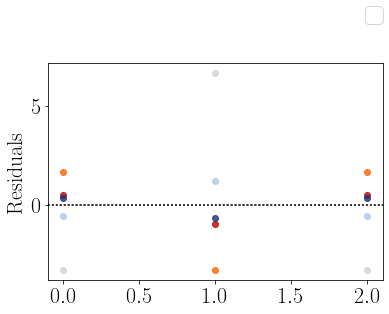

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada         F p-Value (F_0 > F)
     Entre fatores           36.566667                   4       9.141667  0.727454          0.593148
Dentro dos fatores          125.666667                  10      12.566667                            
             Total          162.233333                  14                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the mental demand on each method for blinded users.}
\label{tab:anova_mental_demand}
\begin{tabular}{lrrlll}
\toprule
             Fonte &  Soma dos quadrados &  Graus de liberdade & Média quadrada &     F & p-Value (F\_0 > F) \\
\midrule
     Entre fatores &              36.567 &                   4 &          9.142 & 0.727 &             0.593 \\
Dentro dos fatores &             125.667 &                  10 &         12.567 &       &                   \\
             Total &     

In [222]:
if gerar == True:
    anova = mdNasa_media_cen_par_2[mdNasa_media_cen_par_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = mdNasa_media_cen_par[mdNasa_media_cen_par['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_mental_demand'
caption = 'Anova p-value for the mental demand on each method for blinded users.'
tabela_latex_sem_index(df_summary,label,caption,'Nasa-TLX')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_mental_demand'
caption = 'Cross validation p-value for the mental demand on each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Nasa-TLX')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Carga Mental

No handles with labels found to put in legend.


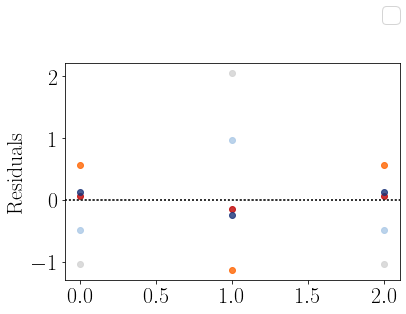

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada         F p-Value (F_0 > F)
     Entre fatores            6.175926                   4       1.543981  0.817202          0.542611
Dentro dos fatores           18.893519                  10       1.889352                            
             Total           25.069444                  14                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the Nasa score on each method for blinded users.}
\label{tab:anova_nasa}
\begin{tabular}{rrrrr}
\toprule
 Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
\midrule
5.417 &  4.833 &        4.833 &         8.000 &    6.083 \\
4.500 &  4.000 &        7.750 &         4.833 &    6.250 \\
4.000 &  3.917 &        4.500 &         5.083 &    3.500 \\
\bottomrule
\end{tabular}
\end{table}

Se a diferença entre alguma média for superior a 1.02 então a hipótese alternativa pode ser v

In [223]:
if gerar == True:
    anova = cmNasa_media_cen_par_2[cmNasa_media_cen_par_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = cmNasa_media_cen_par[cmNasa_media_cen_par['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_nasa'
caption = 'Anova p-value for the Nasa score on each method for blinded users.'
tabela_latex_sem_index(anova,label,caption,'Nasa-TLX')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_nasa'
caption = 'Cross validation p-value for the Nasa score on each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Nasa-TLX')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Sagat

No handles with labels found to put in legend.


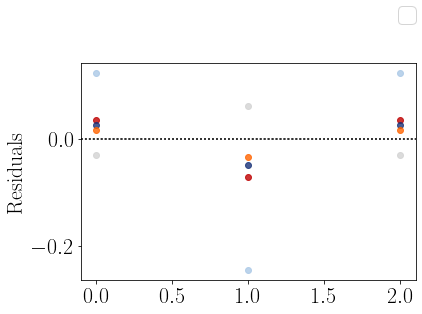

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada         F p-Value (F_0 > F)
     Entre fatores            0.021053                   4       0.005263  0.161577          0.953077
Dentro dos fatores            0.325737                  10       0.032574                            
             Total            0.346790                  14                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the Sagat score on each method for blinded users.}
\label{tab:anova_sagat}
\begin{tabular}{rrrrr}
\toprule
 Base &  Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
\midrule
0.600 &  0.475 &        0.400 &         0.550 &    0.738 \\
0.625 &  0.600 &        0.692 &         0.567 &    0.450 \\
0.863 &  0.875 &        0.799 &         0.683 &    0.900 \\
\bottomrule
\end{tabular}
\end{table}

Se a diferença entre alguma média for superior a 0.13 então a hipótese alternativa pode ser

In [224]:
if gerar == True:
    anova = saSagat_media_cen_par_2[saSagat_media_cen_par_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = saSagat_media_cen_par[saSagat_media_cen_par['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_sagat'
caption = 'Anova p-value for the Sagat score on each method for blinded users.'
tabela_latex_sem_index(anova,label,caption,'Sagat')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_sagat'
caption = 'Cross validation p-value for the Sagat score on each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Sagat')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Tempo

No handles with labels found to put in legend.


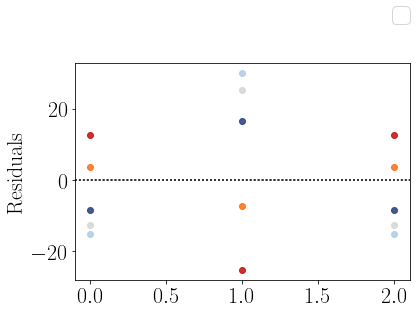

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada       F p-Value (F_0 > F)
     Entre fatores         3427.400000                   4         856.85  1.9063          0.185973
Dentro dos fatores         4494.833333                  10     449.483333                          
             Total         7922.233333                  14                                         
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the duration of each method for blinded users.}
\label{tab:anova_duration}
\begin{tabular}{rrrrr}
\toprule
   Base &   Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
\midrule
357.000 & 327.500 &      346.000 &       392.500 &  355.500 \\
313.000 & 367.000 &      377.000 &       374.500 &  398.000 \\
345.000 & 356.500 &      332.000 &       378.000 &  350.000 \\
\bottomrule
\end{tabular}
\end{table}

Se a diferença entre alguma média for superior a 15.69 então a hipótese alternativa pod

In [225]:
if gerar == True:
    anova = duracao_media_cen_par_2[duracao_media_cen_par_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = duracao_media_cen_par[duracao_media_cen_par['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_duration'
caption = 'Anova p-value for the duration of each method for blinded users.'
tabela_latex_sem_index(anova,label,caption,'Tempo')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_duration'
caption = 'Cross validation p-value for the duration of each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Tempo')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

### Questionarios

No handles with labels found to put in legend.


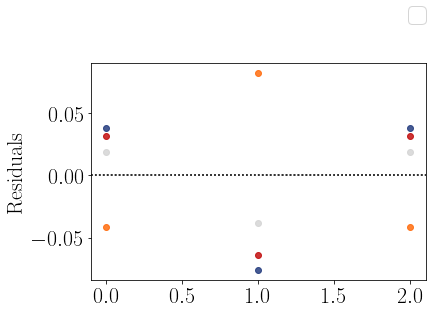

             Fonte  Soma dos quadrados  Graus de liberdade Média quadrada         F p-Value (F_0 > F)
     Entre fatores            0.161507                   3       0.053836  5.537316          0.023616
Dentro dos fatores            0.077779                   8       0.009722                            
             Total            0.239286                  11                                           
-----------------------
-----------------------
\begin{table}[!htb]
\centering
\caption{Anova p-value for the questionnaire score on each method for blinded users.}
\label{tab:anova_sagat}
\begin{tabular}{rrrr}
\toprule
 Audio &  Haptic Belt &  Virtual Cane &  Mixture \\
\midrule
 0.857 &        0.914 &         0.486 &    0.720 \\
 0.631 &        0.714 &         0.457 &    0.849 \\
 0.595 &        0.743 &         0.543 &    0.730 \\
\bottomrule
\end{tabular}
\end{table}

Se a diferença entre alguma média for superior a 0.07 então a hipótese alternativa pode ser valida para essa determi

In [226]:
if gerar == True:
    anova = pgQuestionario_media_2[pgQuestionario_media_2['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)
else:
    anova = pgQuestionario_media[pgQuestionario_media['Visual Impairment'] == 'Blind'].drop('Visual Impairment', axis = 1)

mediaGeral = np.average(anova)

res_amostras = pd.DataFrame([], columns=anova.columns)
for a in anova.columns:
    res_amostras_a = []
    for n_ij in anova[a]:
        res_amostras_a.append(n_ij - mediaGeral)
    res_amostras[a] = res_amostras_a
    #fig = sm.qqplot(res_amostras[a], fit = True, line = 'r')
    #plt.show()
    sns.residplot(y=a, x=res_amostras.index, data = res_amostras)
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Residuals')
#plt.savefig('Nasa-TLX/Figuras/boxplot_md.png',bbox_inches='tight')
plt.show()


df_summary = AnovaTable(anova)
label = 'tab:anova_sagat'
caption = 'Anova p-value for the questionnaire score on each method for blinded users.'
tabela_latex_sem_index(anova,label,caption,'Questionario')
label = 0
caption = 0

lsd = LSDPostHocAnova(anova)
label = 'tab:lsd_sagat'
caption = 'Cross validation p-value for the questionnaire score on each method for blinded users.'
tabela_latex_sem_index(lsd,label,caption,'Questionario')
label = 0
caption = 0

#dun_0 = 
#DunnettPostHocAnova(anova,dun_0,anova['Base'])

## Gráficos

### Gráfico de barra da variação da demanda mental

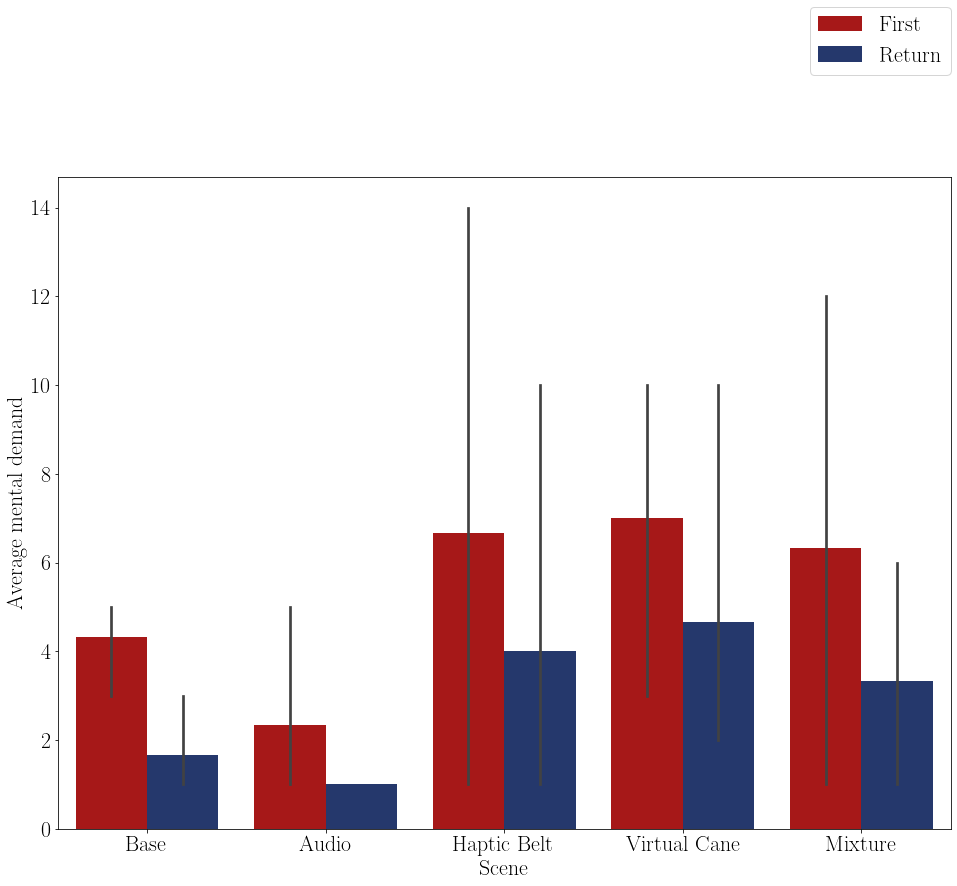

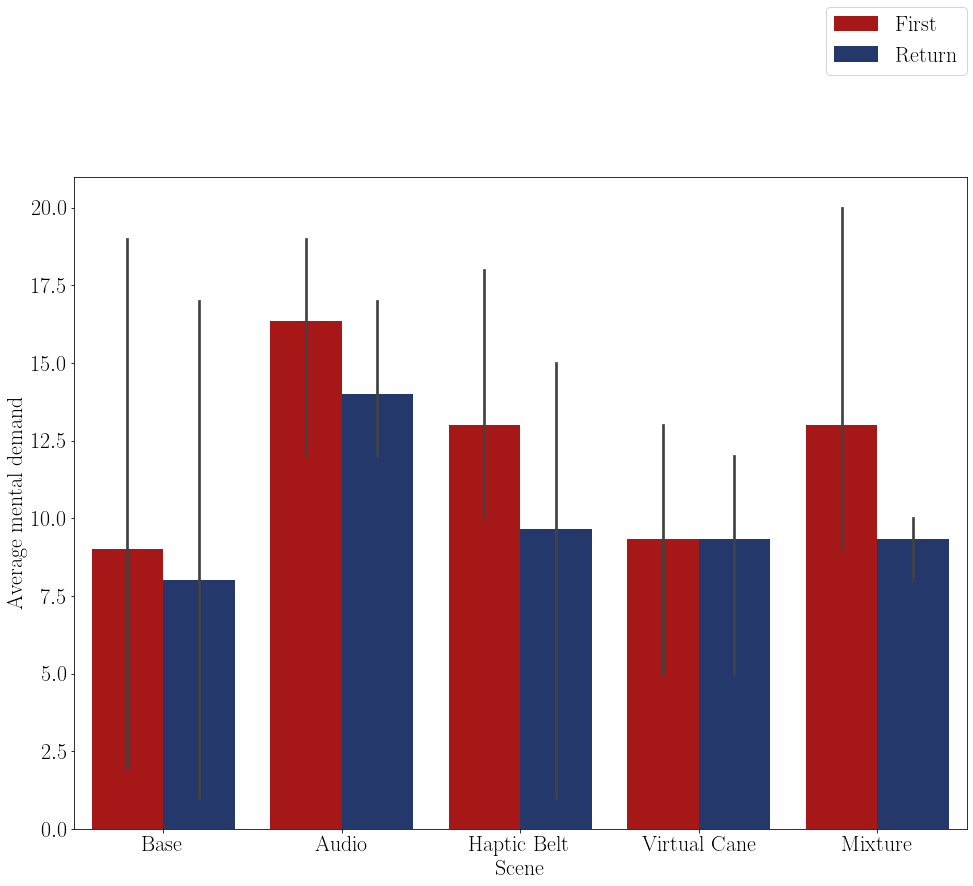

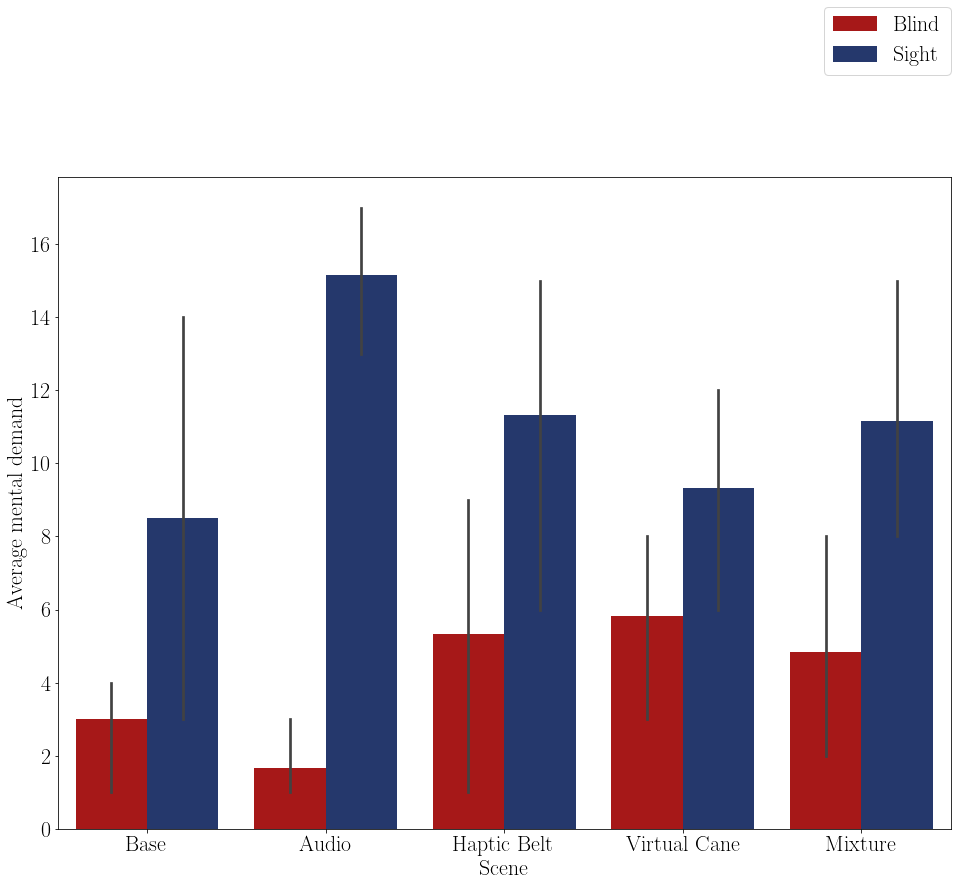

No handles with labels found to put in legend.


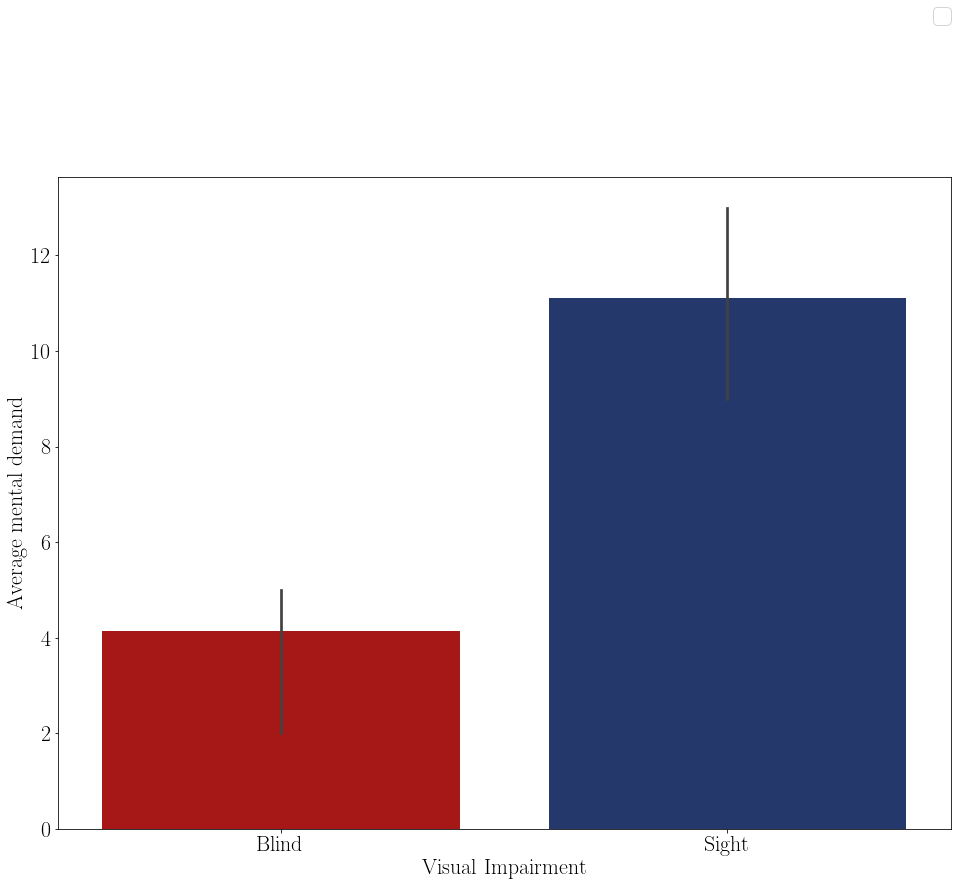

In [227]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfMdVariation_2).reset_index(level = [1,2])
else:
    plot = copy.deepcopy(dfMdVariation).reset_index(level = [1,2])
score = 'mental demand'
teste = 'Nasa-TLX'
label = 'md'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação da carga mental

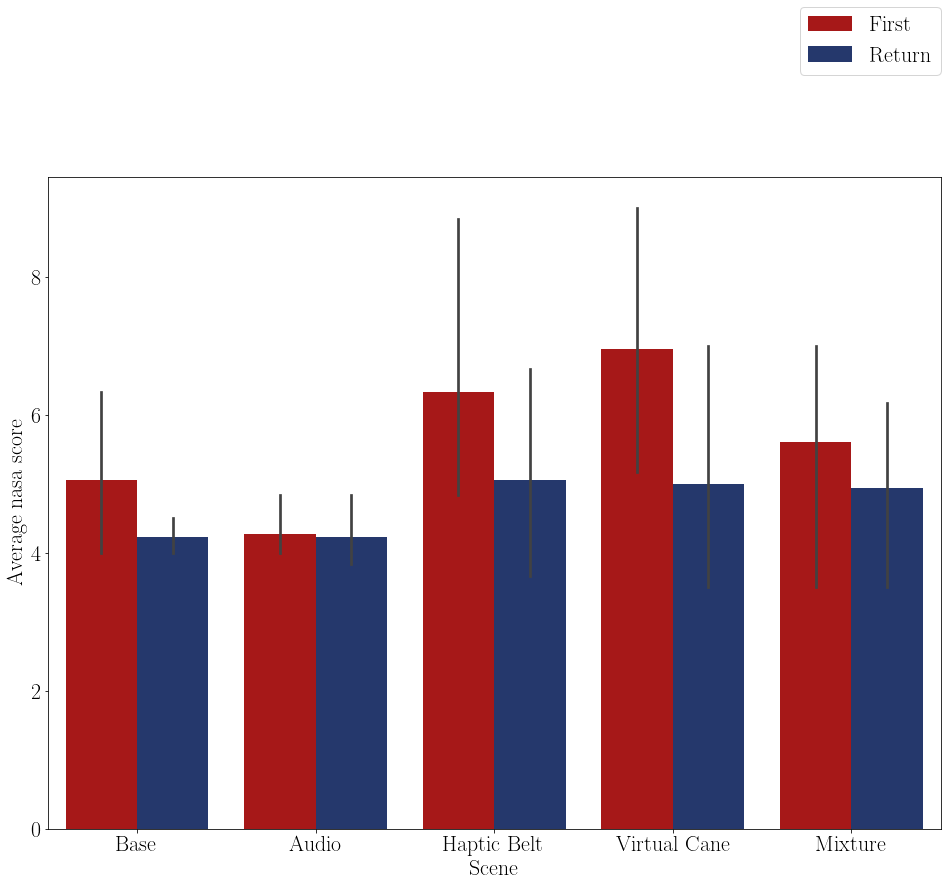

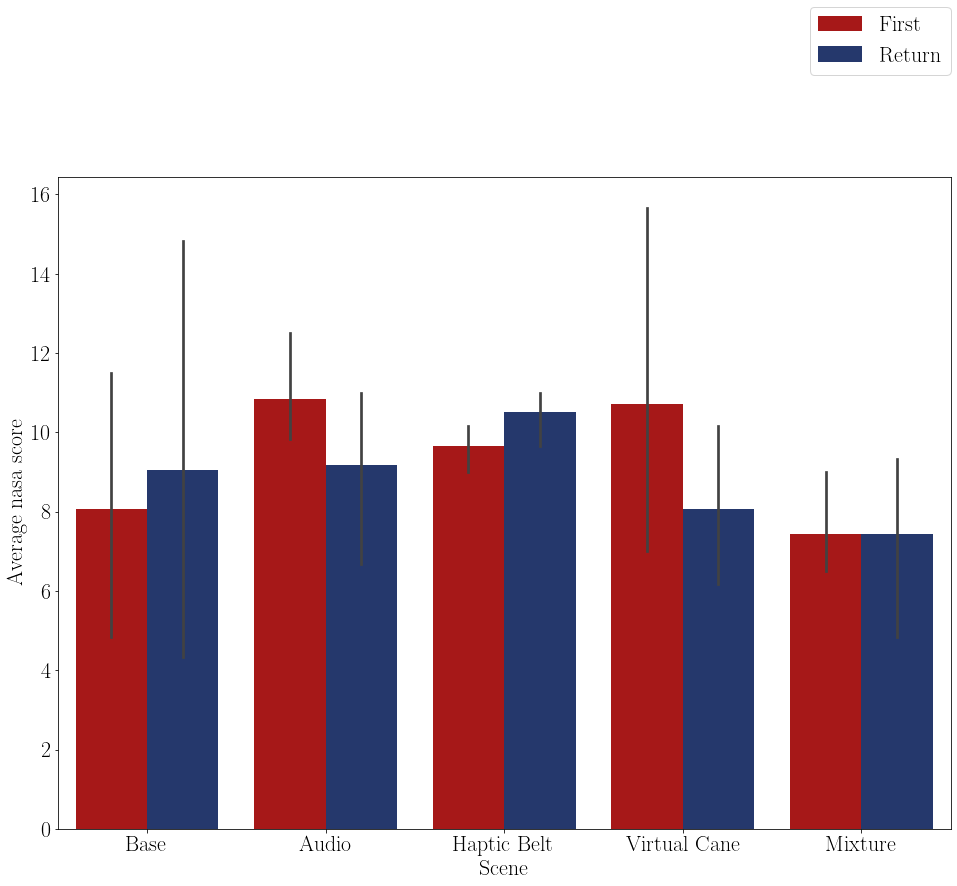

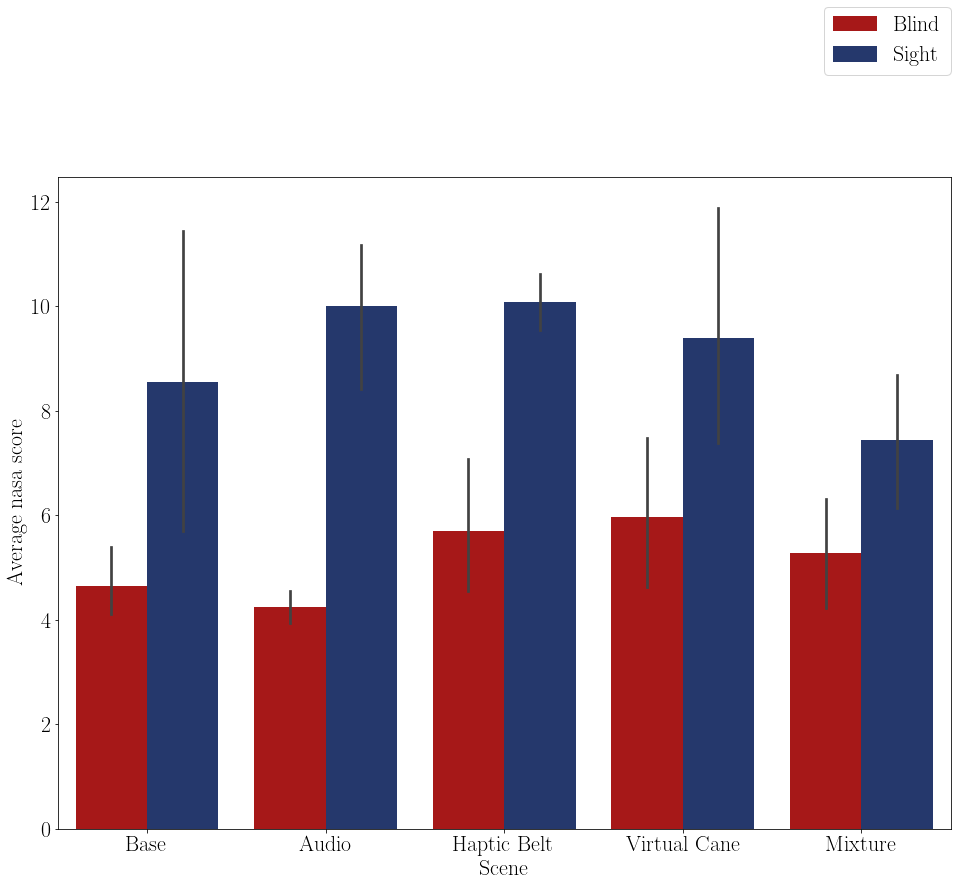

No handles with labels found to put in legend.


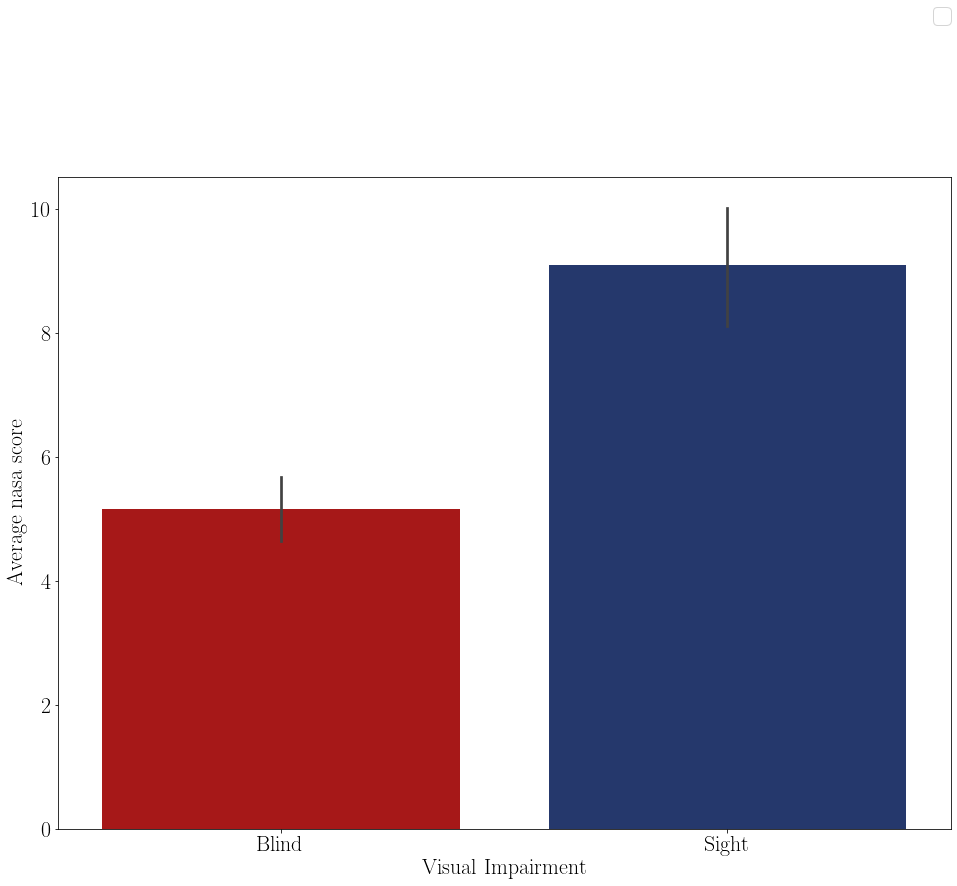

In [228]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfCmVariation_2).reset_index(level = [1,2])
else:
    plot = copy.deepcopy(dfCmVariation).reset_index(level = [1,2])
score = 'nasa score'
teste = 'Nasa-TLX'
label = 'nasa'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação da pontuação do Sagat

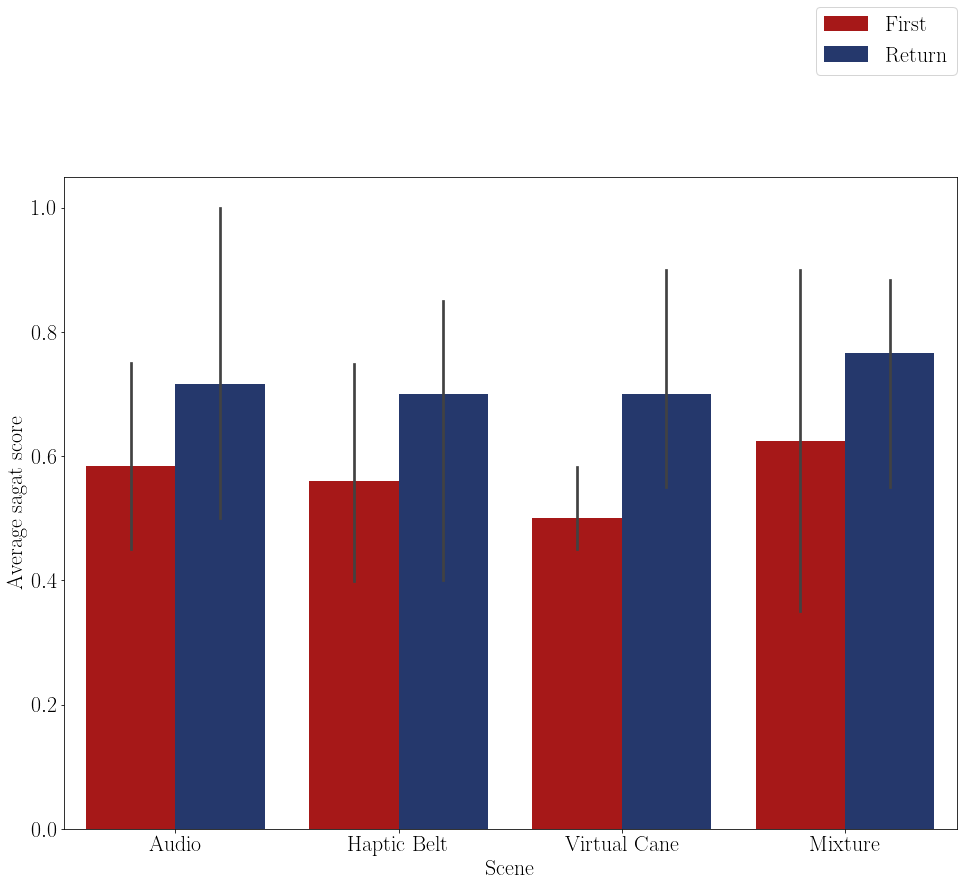

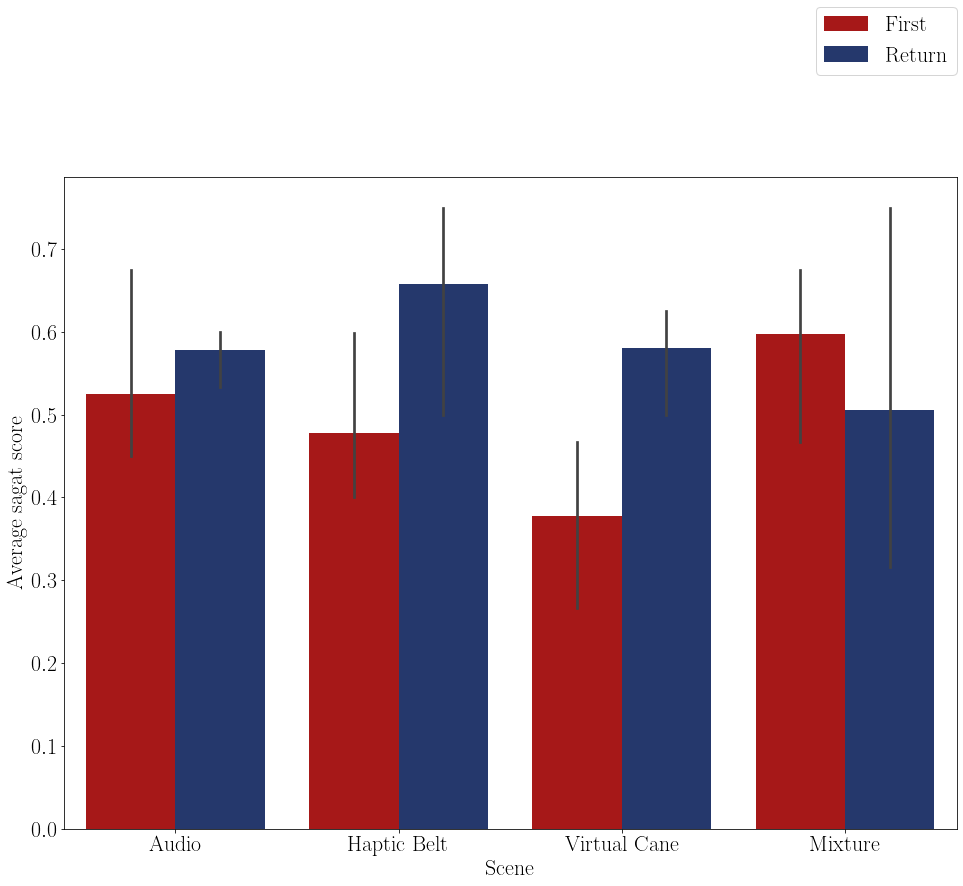

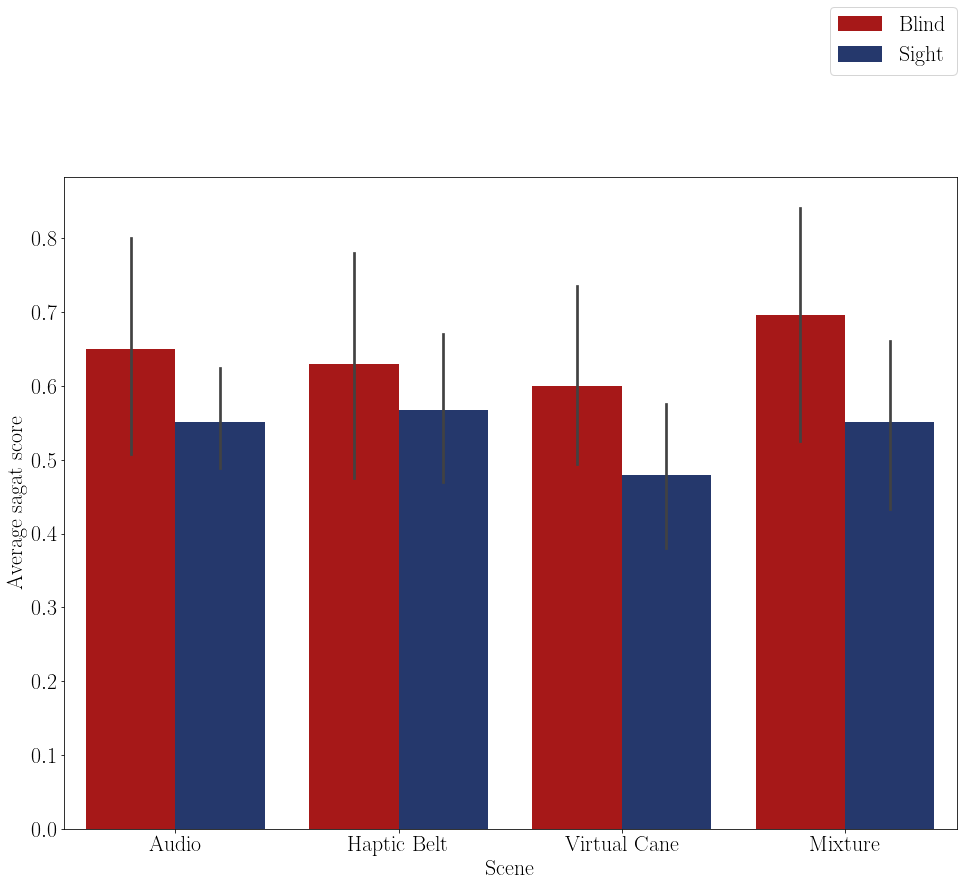

No handles with labels found to put in legend.


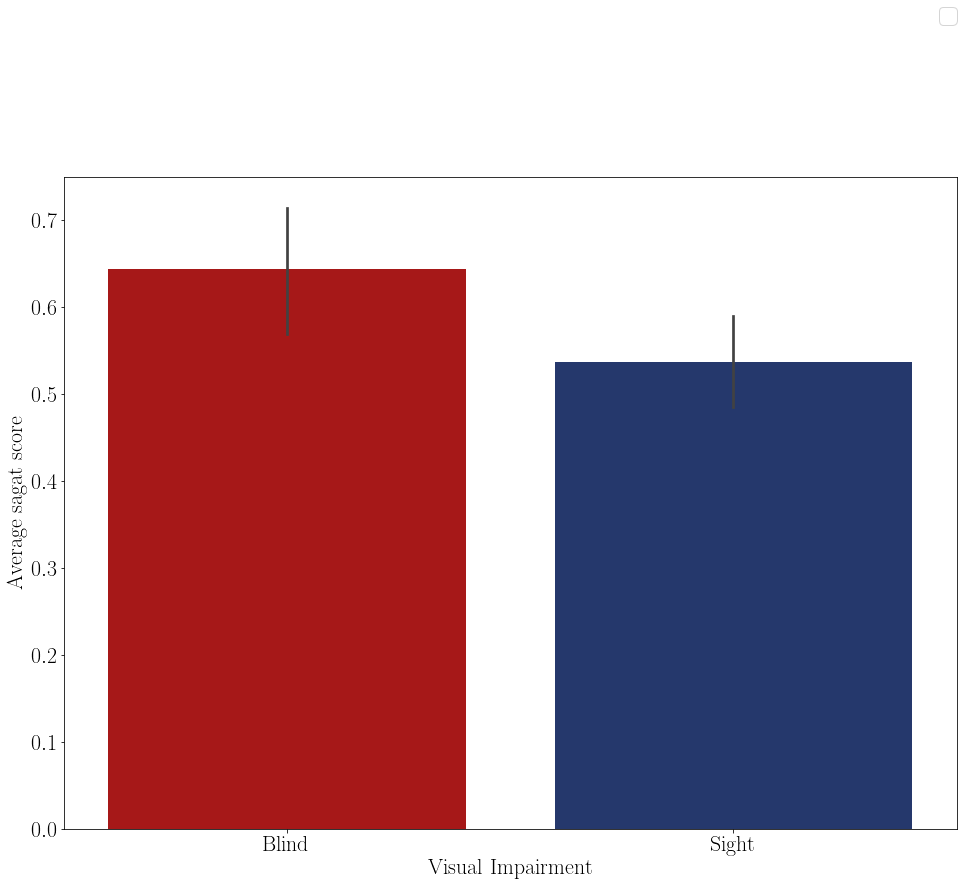

In [229]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfSaVariation_2.drop('Base',axis =1).reset_index(level = [1,2]))
else:
    plot = copy.deepcopy(dfSaVariation.drop('Base',axis =1)).reset_index(level = [1,2])
score = 'sagat score'
teste = 'Sagat'
label = 'sagat'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação do tempo dos participantes

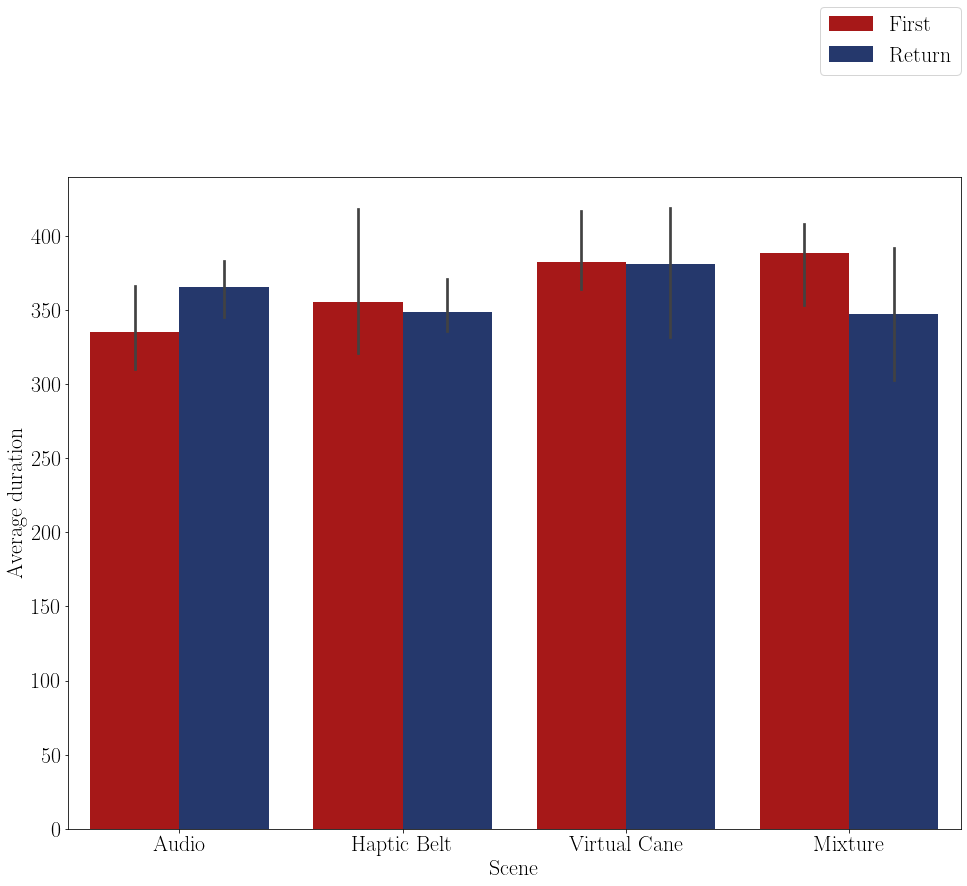

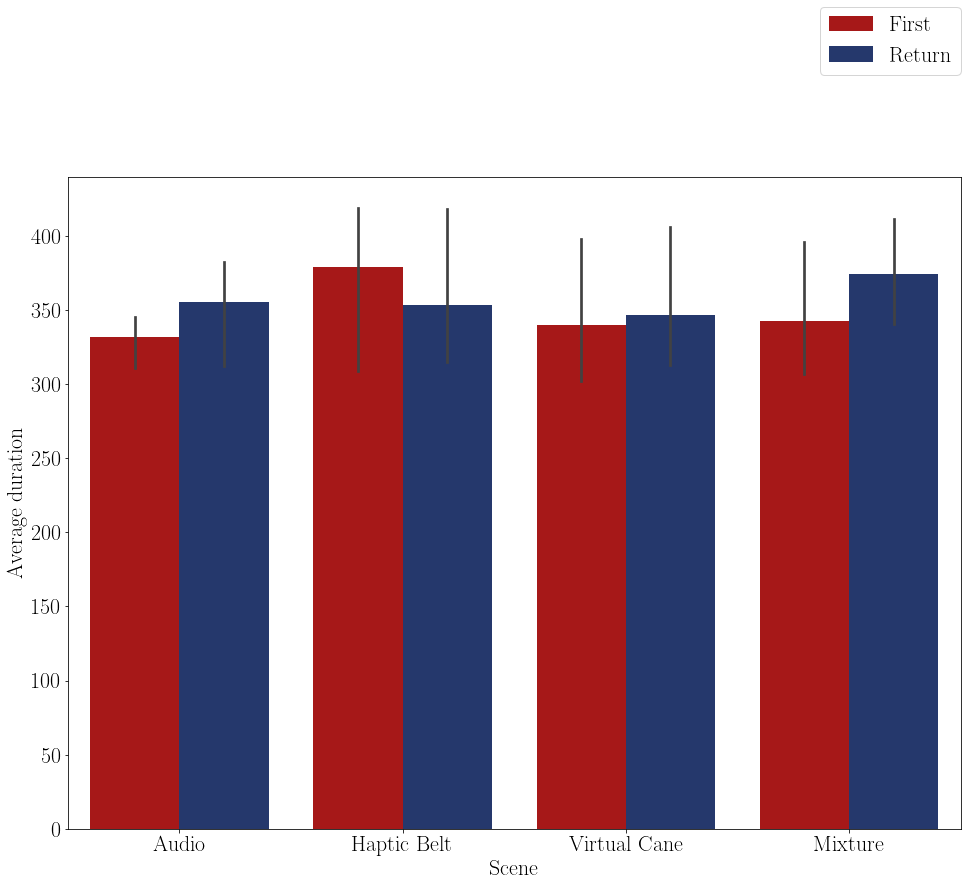

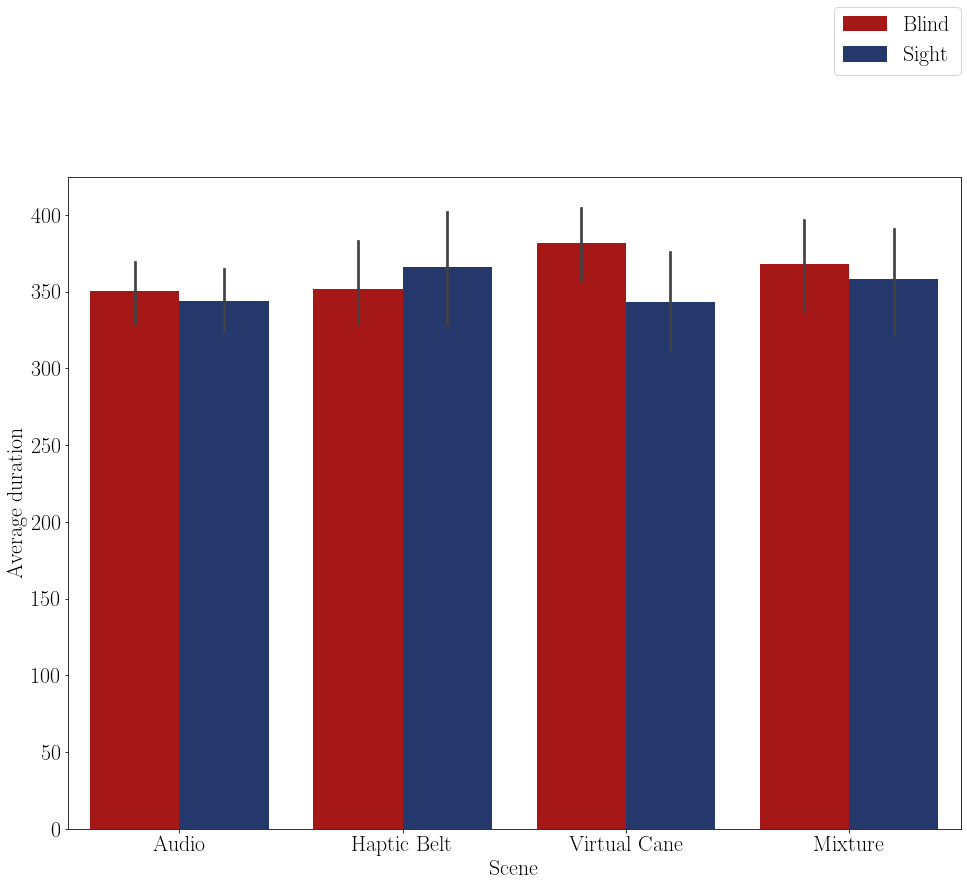

No handles with labels found to put in legend.


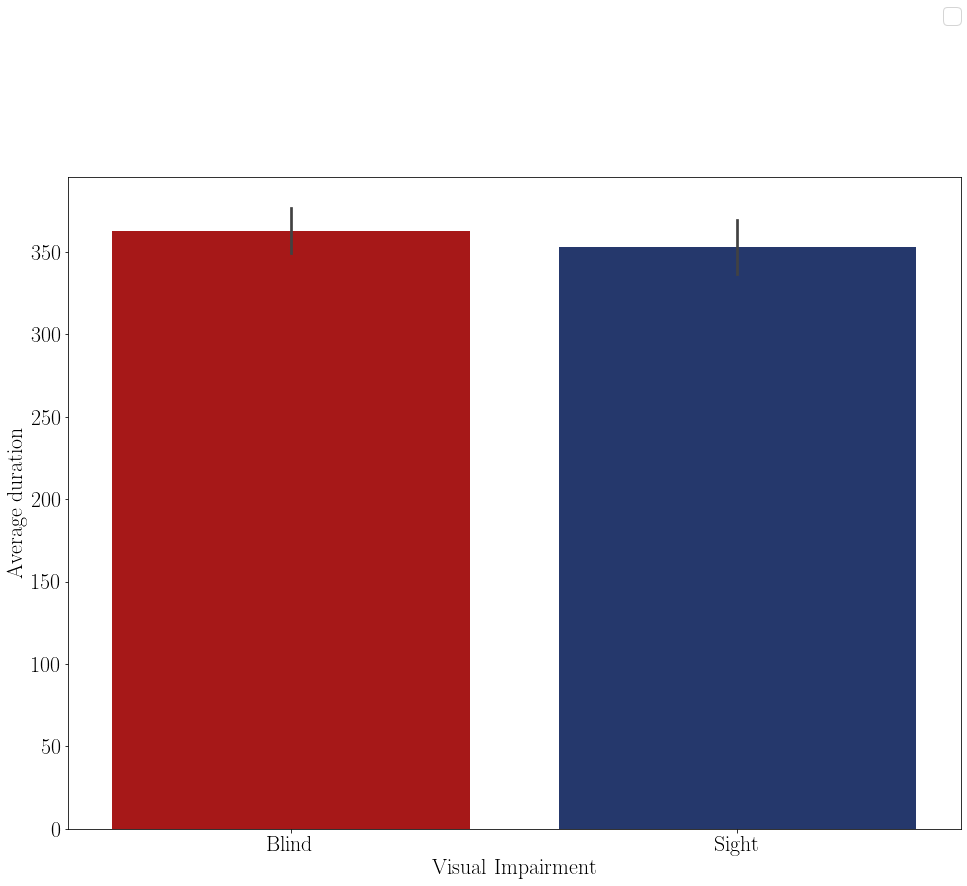

In [230]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfTVariation_2.drop('Base',axis =1).reset_index(level = [1,2]))
else:
    plot = copy.deepcopy(dfTVariation.drop('Base',axis =1)).reset_index(level = [1,2])
score = 'duration'
teste = 'Tempo'
label = 'duration'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Gráfico de barra da variação da pontuação dos questionários

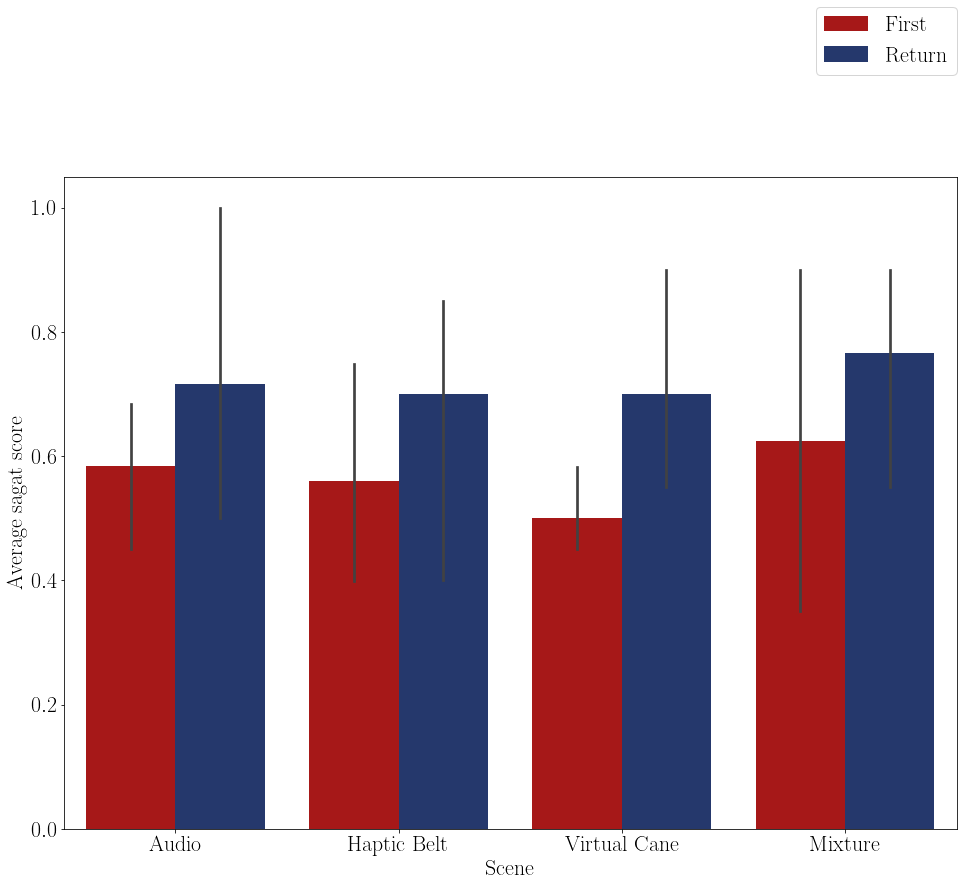

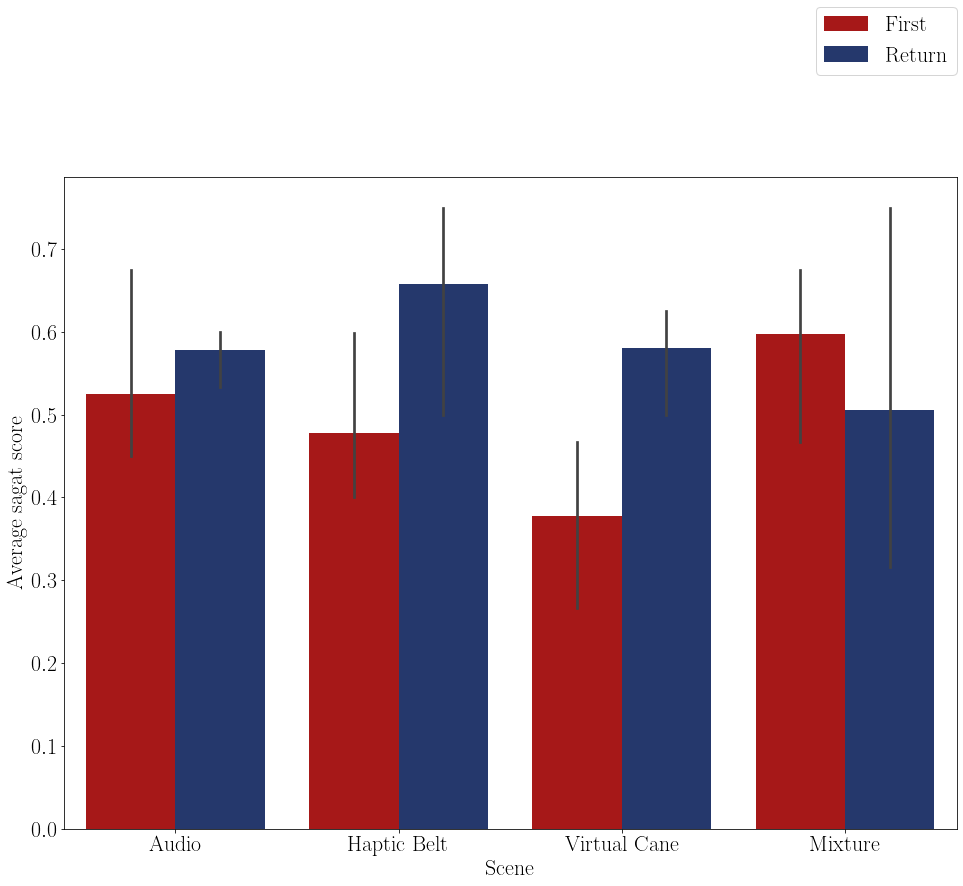

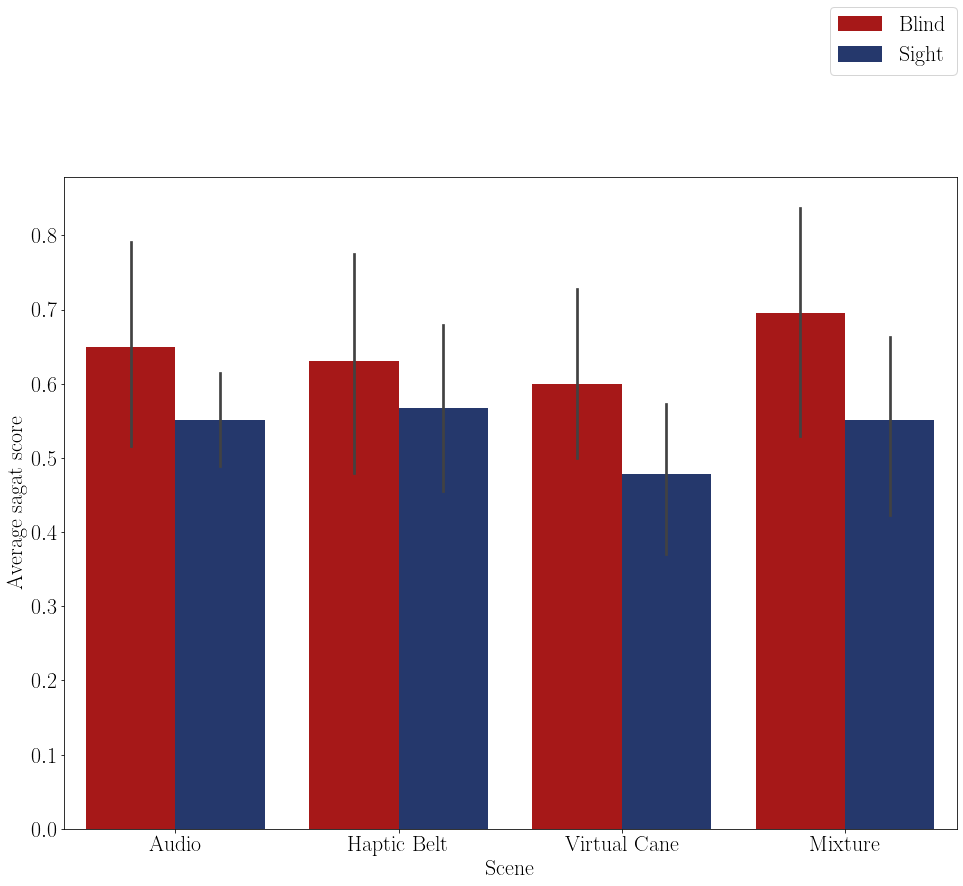

No handles with labels found to put in legend.


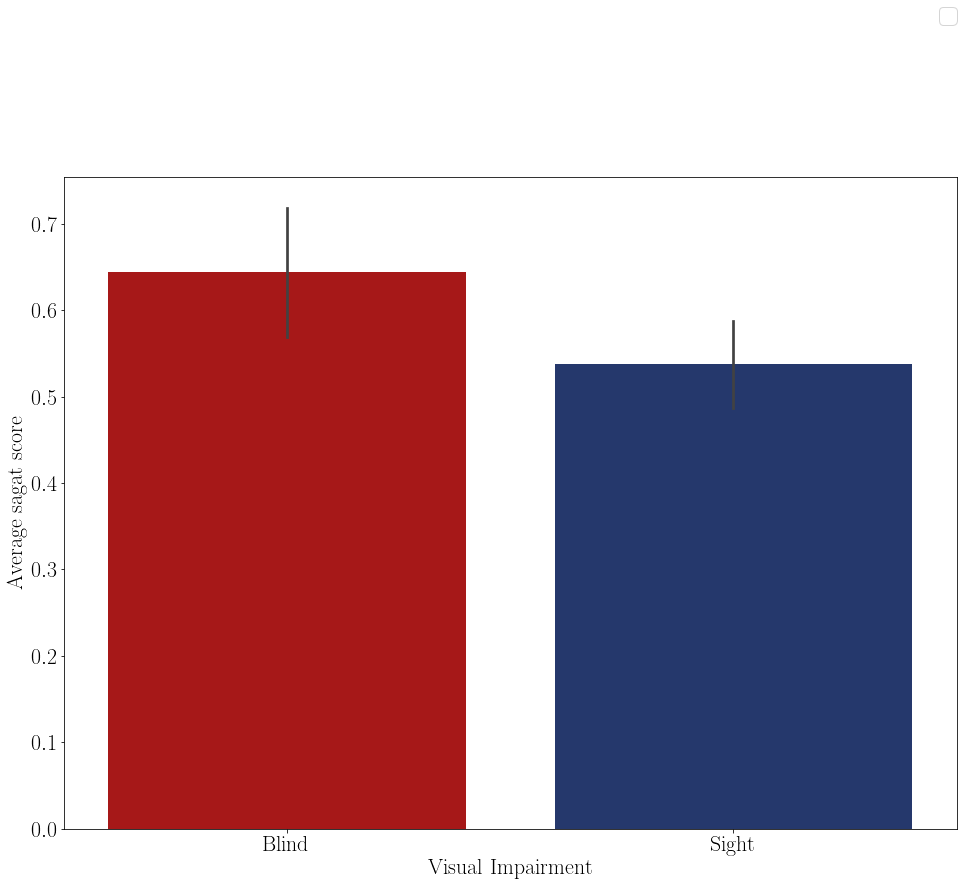

In [231]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(dfSaVariation_2.drop('Base',axis =1).reset_index(level = [1,2]))
else:
    plot = copy.deepcopy(dfSaVariation.drop('Base',axis =1)).reset_index(level = [1,2])
score = 'sagat score'
teste = 'Sagat'
label = 'sagat'

mdMelt = pd.melt(plot.reset_index(),id_vars = ['Participant','Round','Visual Impairment'], var_name = 'Scene', value_name = 'Score',ignore_index=True)
mdMelt.set_index('Participant')

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Blind'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/barplot_' + label + '_scene_blind.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/barplot_' + label + '_scene_blind.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt[mdMelt['Visual Impairment'] == 'Sight'], x = 'Scene', y = 'Score', hue = 'Round')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene_sight.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene_sight.pgf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 12))
sns.barplot(data = mdMelt, x = 'Scene', y = 'Score', hue = 'Visual Impairment')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

sns.barplot(data = mdMelt, x = 'Visual Impairment', y = 'Score')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média da demanda mental

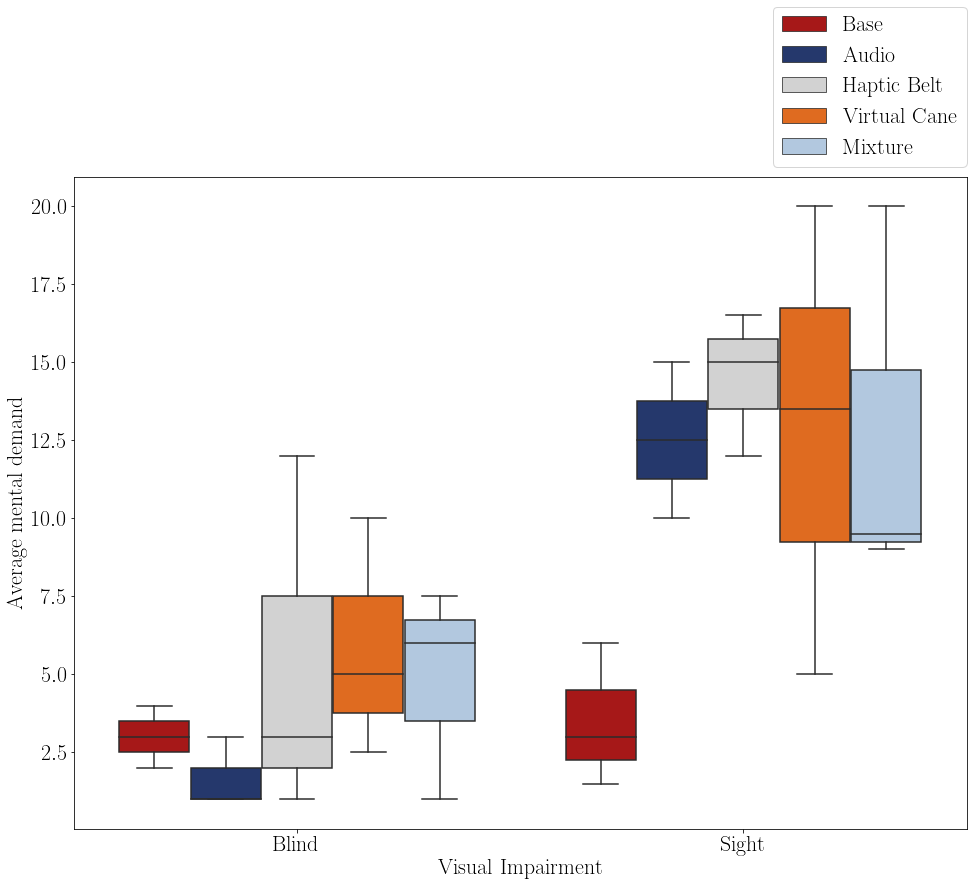

No handles with labels found to put in legend.


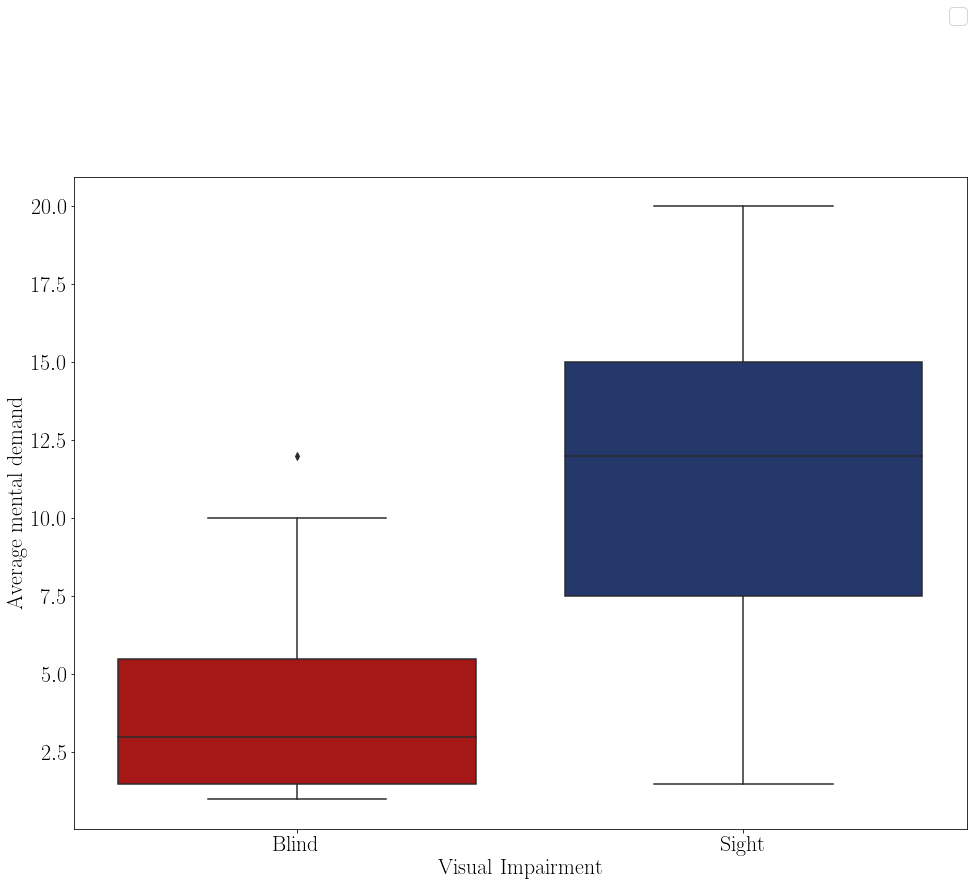

In [232]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(mdNasa_media_cen_par_2)
else:
    plot = copy.deepcopy(mdNasa_media_cen_par)
score = 'mental demand'
teste = 'Nasa-TLX'
label = 'md'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média da Carga Mental

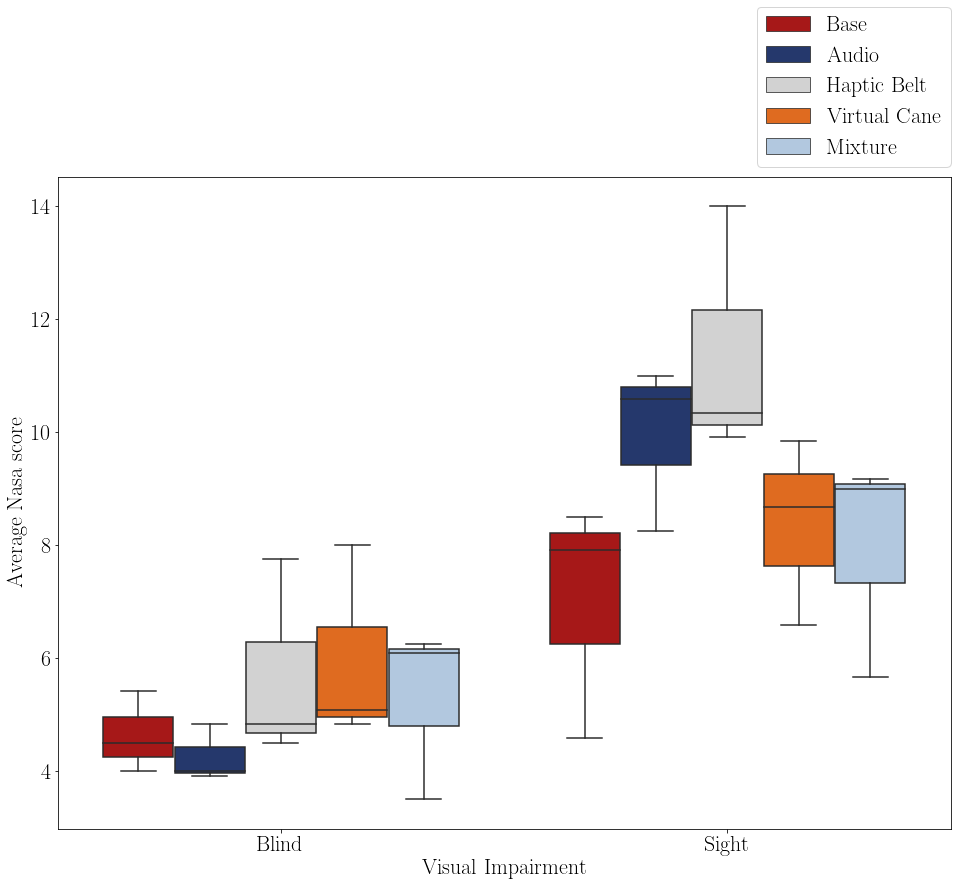

No handles with labels found to put in legend.


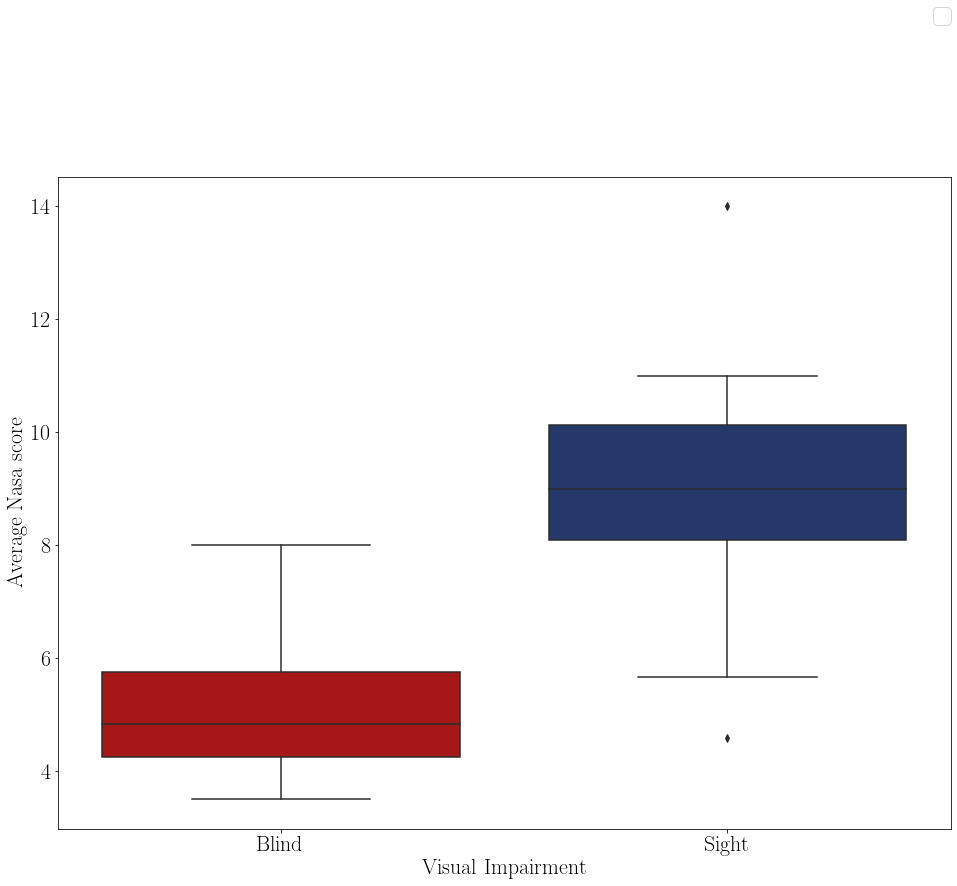

In [233]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(cmNasa_media_cen_par_2)
else:
    plot = copy.deepcopy(cmNasa_media_cen_par)

score = 'Nasa score'
teste = 'Nasa-TLX'
label = 'nasa'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média do SAGAT

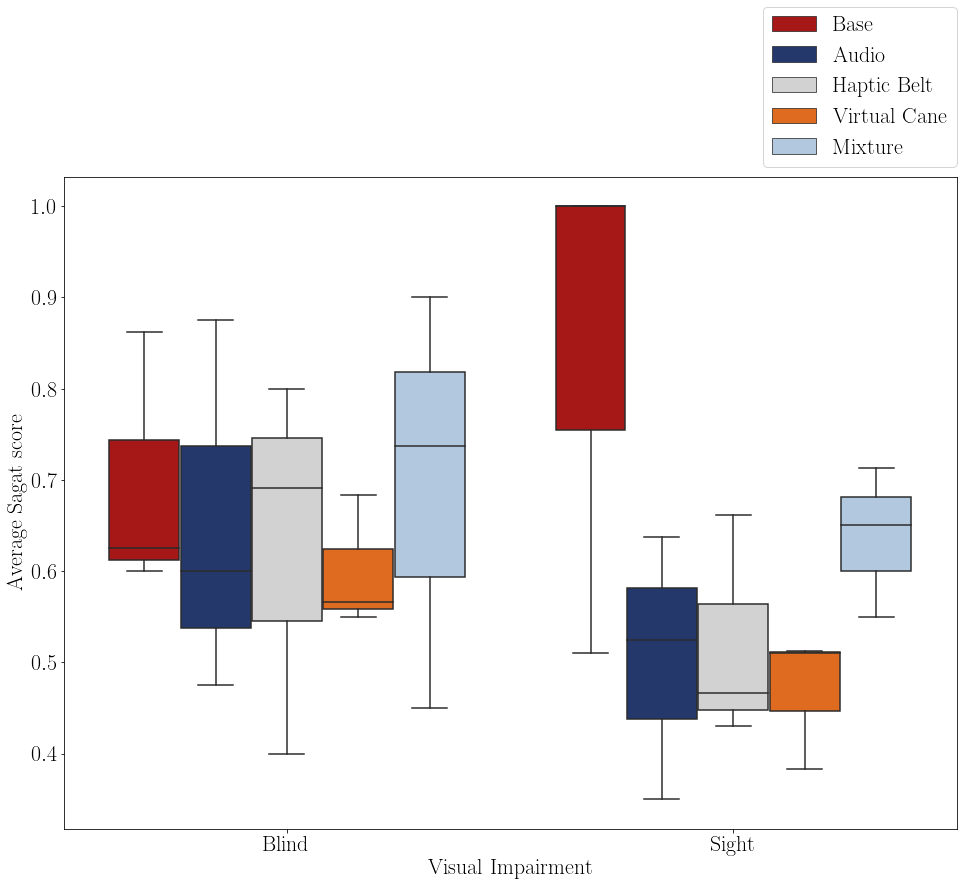

No handles with labels found to put in legend.


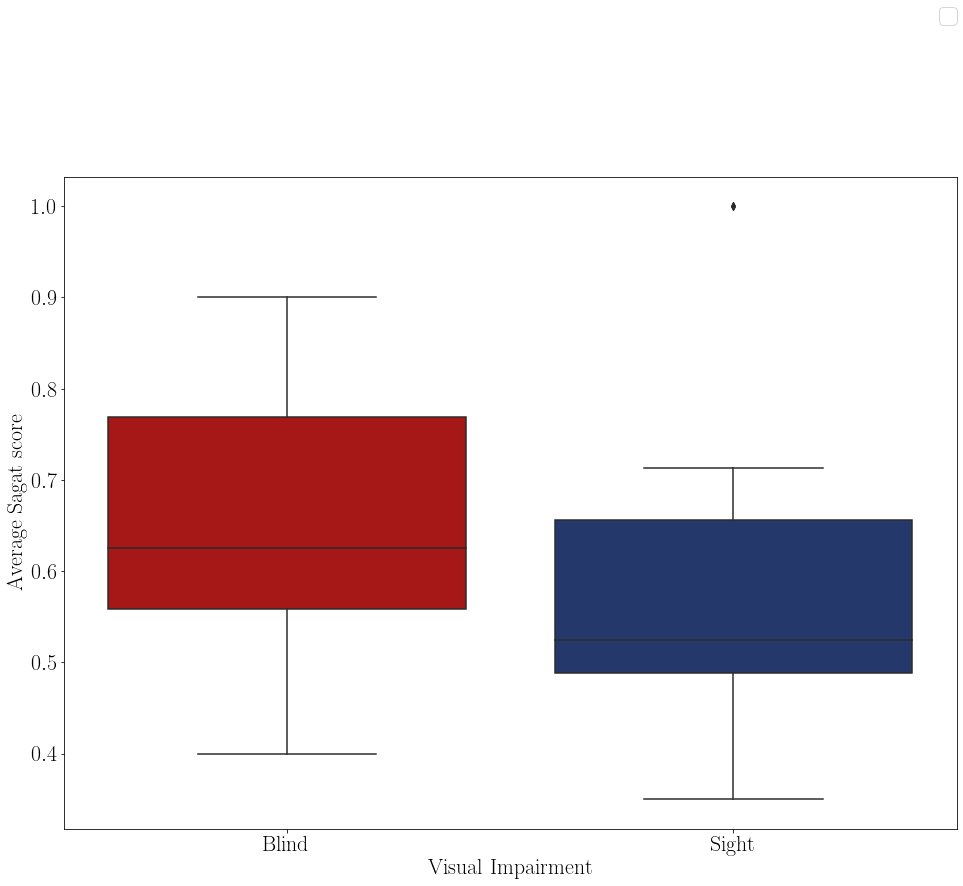

In [234]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(saSagat_media_cen_par_2)
else:
    plot = copy.deepcopy(saSagat_media_cen_par)

score = 'Sagat score'
teste = 'SAGAT'
label = 'sagat'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média do tempo

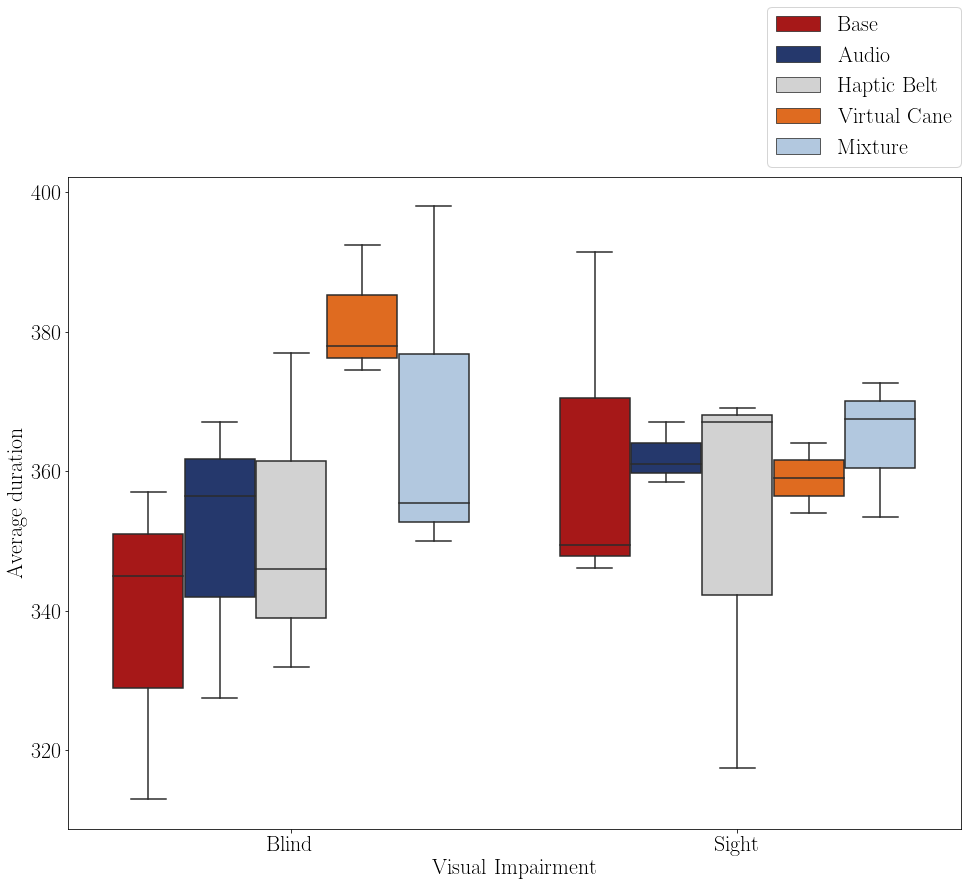

No handles with labels found to put in legend.


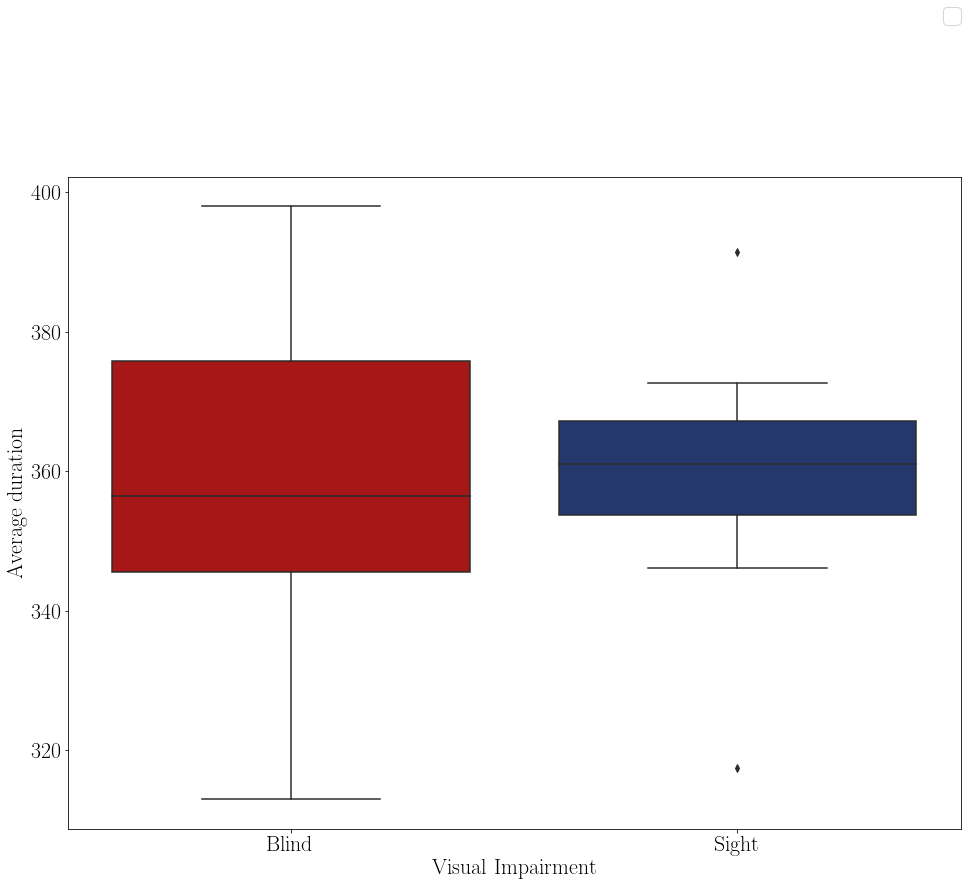

In [235]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(duracao_media_cen_par_2)
else:
    plot = copy.deepcopy(duracao_media_cen_par)

score = 'duration'
teste = 'Tempo'
label = 'duration'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()

### Box plot da média dos Questionario

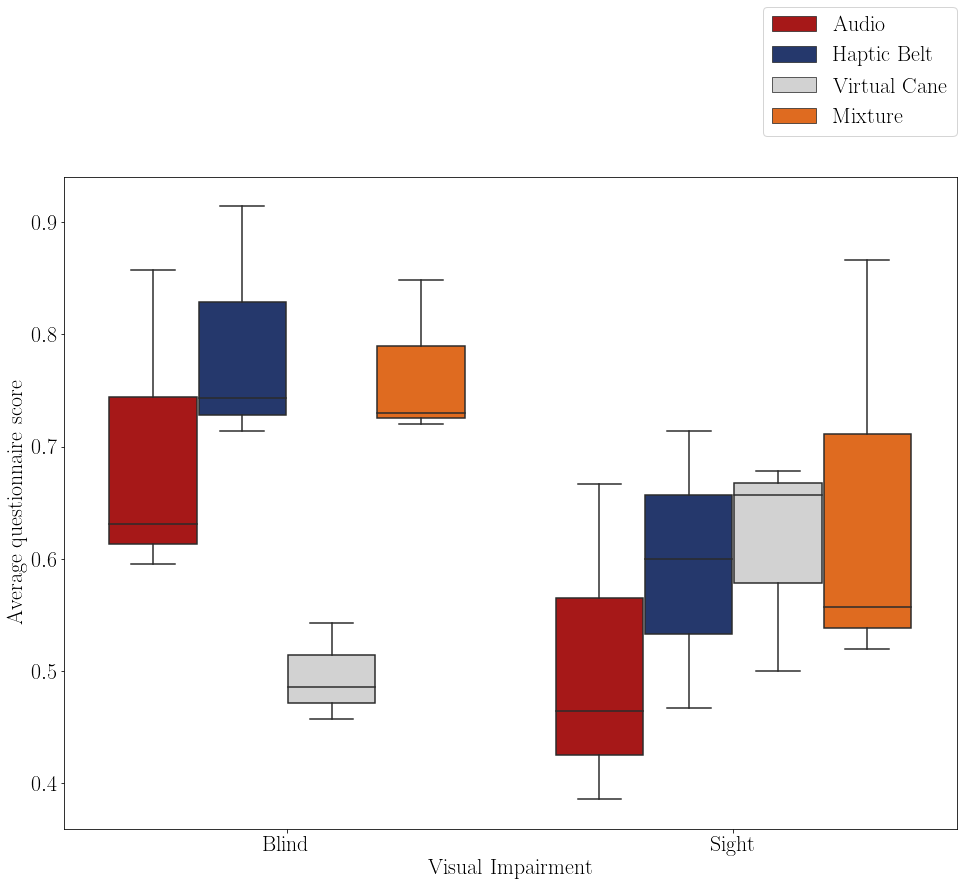

No handles with labels found to put in legend.


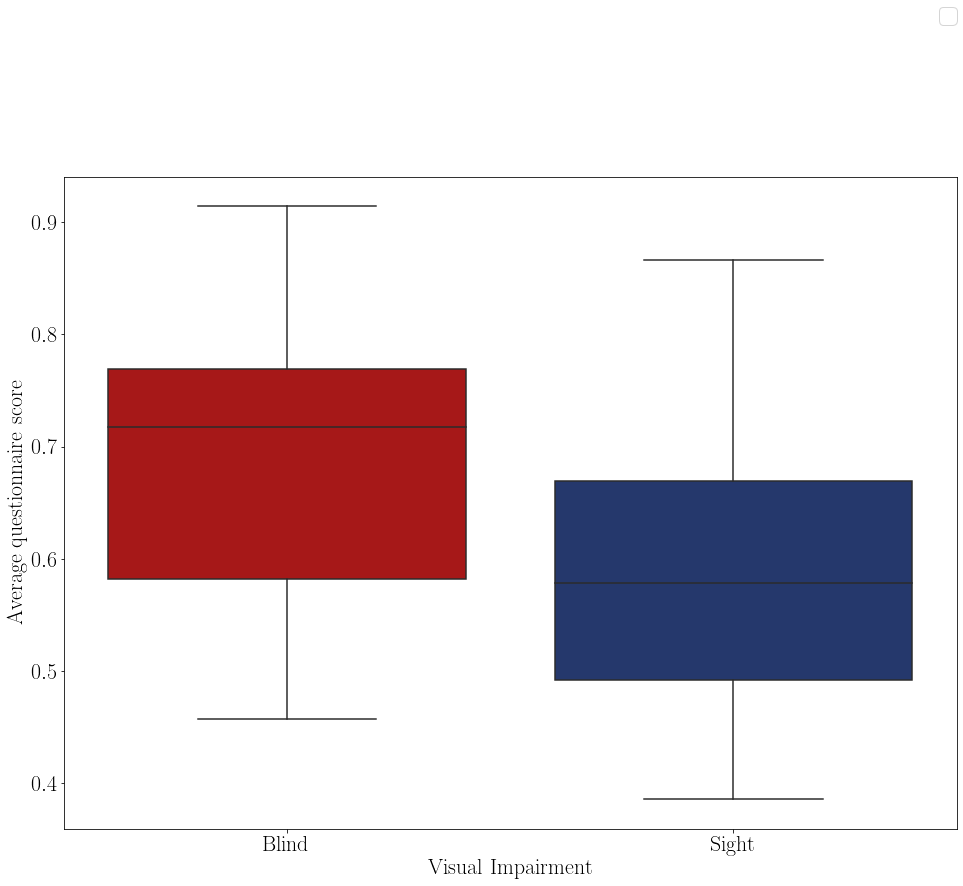

In [236]:
# Gerar um box plot de todas as médias dos participantes em cada cena
if gerar == True:
    plot = copy.deepcopy(pgQuestionario_media_2)
else:
    plot = copy.deepcopy(pgQuestionario_media)

score = 'questionnaire score'
teste = 'Questionario'
label = 'questionnaire'

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

plt.figure(figsize=(16, 12))
sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average', hue = "Scene")
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '_scene.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '_scene.pgf',bbox_inches='tight')
plt.show()


plt.figure(figsize=(16, 12))

plot.loc[plot['Visual Impairment'] == 0, 'Visual Impairment'] = "Sight"
plot.loc[plot['Visual Impairment'] == 1, 'Visual Impairment'] = "Blind"

mdMelt = pd.melt(plot,id_vars = 'Visual Impairment', var_name = 'Scene', value_name = 'Average')

sns.boxplot(data = mdMelt, x = 'Visual Impairment', y = 'Average')
plt.legend(bbox_to_anchor=(1, 1.26), loc='upper right', borderaxespad=0)
plt.ylabel('Average ' + score)
plt.savefig(teste + '/Figuras/png/boxplot_' + label + '.png',bbox_inches='tight')
plt.savefig(teste + '/Figuras/boxplot_' + label + '.pgf',bbox_inches='tight')
plt.show()